In [1]:
import numpy as np
import xarray as xr
import xrft
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.patches as patches
import cmocean as cm
import seaborn as sns
 
def_colours = [(0.00000, 0.44706, 0.69804),
          (0.00000, 0.61961, 0.45098),
          (0.94118, 0.89412, 0.25882),
          (0.90196, 0.62353, 0.00000),
          (0.83529, 0.36863, 0.00000),
          (0.80000, 0.47451, 0.65490),
          (0.33725, 0.70588, 0.91373)]

plt.rcParams["text.usetex"] = True
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = 'Times'

### Monoscale topography

In [ ]:
def isotropic_spec(_var):
    '''This function does what pyqg's native calc.ispec does, which relies on having the model instance.
    I therefore mostly copy the synax of their function.
    
    Parameters
    ----------
    var_dens : squared modulus of fourier coefficients like this:
        `np.abs(signal2d_fft)**2/m.M**2`
    
    Returns
    -------
    kr : array
        isotropic wavenumber
    phr : array
        isotropic spectrum
    '''
    
    # variables
    var = np.copy(_var)
    var[..., 0] /= 2
    var[..., -1] /= 2
    
    # grid
    dk = 2 * np.pi / L
    k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
    l = k
    kk, ll = np.meshgrid(k, l)
    KK = np.sqrt(kk ** 2 + ll ** 2)
    
    k_max = np.abs(k).max()
    l_max = np.abs(l).max()
    K_max = np.minimum(k_max, l_max)
    K_min = 0.
    
    dk = k[1] - k[0]
    dl = l[1] - l[0]
    dK = np.sqrt(dk ** 2 + dl ** 2)
    
    # left border of bins
    K = np.arange(K_min, K_max, dK)
    ph = np.zeros(K.size)
    
    for i in range(K.size):
        if i == K.size - 1:
            fK = (KK >= K[i]) & (KK <= K[i] + dK)
        else:
            fK = (KK >= K[i]) & (KK < K[i + 1])
            
        ph[i] = 2 * np.pi * var[fK].mean() * (K[i] + dK / 2) / (dk * dl)
        
    # convert left border of the bin to center
    K = K + dK / 2
    
    return K, ph


def monoscale_random(L, N, Ktopo, h_star, seed):
    '''
    Takes in a square grid, and minimum and maximum isotropic wavenumbers
    and returns a isotropic, homogeneous, monoscale topographic field.
    
    Inputs:
    L : side length of square box
    N : number of grid points in x and y
    K_0 : central normalized (i.e., integer) isotropic minimum wavenumber
    h_rms : desired root mean square topographic height
    
    Ouputs:
    eta : topographic field (2D array shape (N, N))
    '''
    
    # Get hrms from hstar
    hrms = h_star * U0 * H0 * Ktopo / f0
    
    # Standard deviation for |\hat \psi|^2 in isotropic wavenumber space so that std = 1 with normalized wavenumbers
    sigma = 2 * np.pi / L
    
    # Isotropic Gaussian in wavenumber space
    np.random.seed(seed)
    etah = np.exp(-(K - Ktopo) ** 2 / (4 * sigma ** 2)) * np.exp(2 * np.pi * 1j * np.random.randn(N, N))

    # Recover eta from eta_h
    eta = np.real(np.fft.ifftn(etah, axes = (-2, -1)))
    
    c = hrms / np.sqrt(np.mean(eta**2))
    eta = c * eta
    
    return eta

In [54]:
### Import topography from one of my simulations ###

ds = xr.open_dataset('/scratch/mp6191/GeophysicalFlows_expts/kappa02_kt25_h5/output/kappa02_kt25_h5.nc')
h = ds.htop.values

### Parameters ###

Ld = 15e3
kd = 1 / Ld
ld = 2 * np.pi / kd
L = 25 * ld
N = 1024
x = np.linspace(0., L, N)
y = np.linspace(0., L, N)
xx, yy = np.meshgrid(x, y)
    
# Define horizontal structure of PV
dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2
K = np.sqrt(K2)

f0 = 1e-4
U0 = 0.01
H0 = 4000.
Ktopo = 1 * kd

hrms = np.sqrt(np.mean(h ** 2))
hh = np.fft.fftn(h, axes = (-2, -1))
Kr, h_spec = isotropic_spec(np.abs(hh) ** 2 / hrms ** 2)

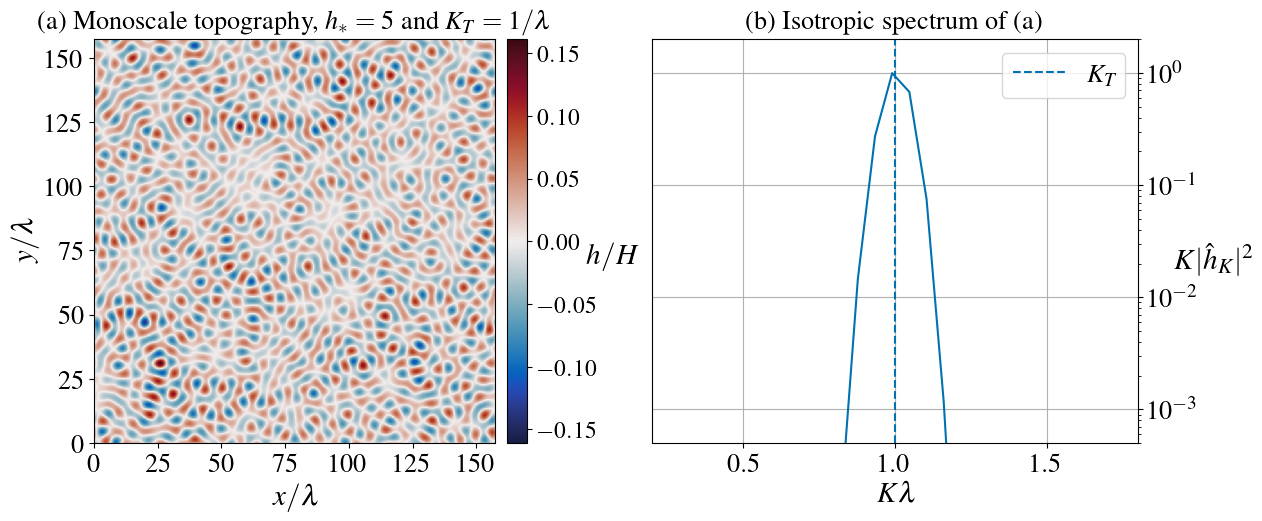

In [58]:
fig, axs = plt.subplots(figsize = (11.5, 5), nrows = 1, ncols = 2)
fig.tight_layout(pad = 2.5)
fontsize = 19

### Panel (a)
ax = axs[0]
vmax = np.abs(h / H0).max()
vmin = -vmax
pmesh = ax.pcolormesh(xx / Ld, yy / Ld, h / H0, vmin = vmin, vmax = vmax, cmap = cm.cm.balance)
cbar = plt.colorbar(pmesh, pad = 0.025)#, ticks = np.linspace(-0.10, 0.10, 5, endpoint = True))
cbar.ax.tick_params(labelsize = fontsize - 2)

ax.set_xlabel(r'$x / \lambda$', fontsize = fontsize + 2)
ax.set_ylabel(r'$y / \lambda$', fontsize = fontsize + 2)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
cbar.set_label(r'$h / H$', rotation = 0, fontsize = fontsize + 2, labelpad = 10)
ax.set_title('(a) Monoscale topography, $h_* = 5$ and $K_T = 1 / \lambda$', fontsize = fontsize, pad = 7.5)

### Panbel (b)
ax = axs[1]
imin = 4
imax = 32
ymin = 5e-4
ymax = 2
ax.plot(Kr[imin:imax] * Ld, h_spec[imin:imax] / np.max(h_spec[imin:imax]), '-', color = def_colours[0])
ax.vlines(Ktopo * Ld, ymin, ymax, colors = def_colours[0], linestyles = '--', label = f'$K_T$')

ax.set_xlabel(r'$K\lambda$', fontsize = fontsize + 2)
ax.set_ylabel(r'$K|\hat{h}_{K}|^2$', rotation = 0, fontsize = fontsize + 2, labelpad = 10)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_title('(b) Isotropic spectrum of (a)', fontsize = fontsize, pad = 7.5)
ax.set_yscale('log')
ax.set_ylim([ymin, ymax])
ax.set_xlim([0.2, 1.8])
ax.set_xticks(np.arange(0.5, 2., 0.5))
ax.grid()
ax.legend(fontsize = fontsize)

plt.subplots_adjust(wspace = 0.15)

plt.savefig('monoscale_topography.png', dpi=500, bbox_inches='tight')

### Monoscale topography eddy scale sweep 

In [5]:
# Import L50 runs
path = '/scratch/mp6191/GeophysicalFlows_expts/L50Runs'
expts = ['/kappa016_notopo', '/kappa016_kt50_h2', '/kappa016_kt50_h4', '/kappa016_kt50_h6', '/kappa016_kt50_h6.25', '/kappa016_kt50_h6.5', '/kappa016_kt50_h7', '/kappa016_kt50_h8', '/kappa016_kt50_h10', '/kappa016_kt50_h12', '/kappa016_kt50_h14', '/kappa016_kt50_h16']
names = [expt[1:] for expt in expts]

# Import simulations
expt_dict = dict()
for i in range(len(expts)):
    name = names[i]
    path_kt50 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt50_h6.25']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    elif name in ['kappa016_kt50_h6']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart3.nc'
    ds = xr.open_dataset(path_kt50)
    expt_dict[name] = ds

path = '/scratch/mp6191/GeophysicalFlows_expts/L50Runs'
expts = ['/kappa016_kt100_h1', '/kappa016_kt100_h2', '/kappa016_kt100_h3', '/kappa016_kt100_h4', '/kappa016_kt100_h5', '/kappa016_kt100_h5.5', '/kappa016_kt100_h6', '/kappa016_kt100_h7', '/kappa016_kt100_h8']
names = [expt[1:] for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names[i]
    path_kt100 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt100_h5']:
        path_kt100 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt100)
    expt_dict[name] = ds


# Import L25 runs
path = '/scratch/mp6191/GeophysicalFlows_expts'
expts = ['/kappa02_notopo', '/kappa02_kt25_h2', '/kappa02_kt25_h3', '/kappa02_kt25_h4', '/kappa02_kt25_h4.5', '/kappa02_kt25_h5', '/kappa02_kt25_h6', '/kappa02_kt25_h8', '/kappa02_kt25_h9', '/kappa02_kt25_h10', '/kappa02_kt25_h12', '/kappa02_kt25_h14', '/kappa02_kt25_h16',
         '/kappa03_notopo', '/kappa03_kt25_h1', '/kappa03_kt25_h1.5', '/kappa03_kt25_h2', '/kappa03_kt25_h2.5', '/kappa03_kt25_h3', '/kappa03_kt25_h4', '/kappa03_kt25_h5', '/kappa03_kt25_h6', '/kappa03_kt25_h8', '/kappa03_kt25_h9', '/kappa03_kt25_h10', '/kappa03_kt25_h12', '/kappa03_kt25_h14', '/kappa03_kt25_h16',
        '/kappa10_notopo', '/kappa10_kt25_h2', '/kappa10_kt25_h4', '/kappa10_kt25_h8', '/kappa10_kt25_h12', '/kappa10_kt25_h16']
names = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names[i]
    path_kt25 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt25_h5.75']:
        path_kt25 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt25)
    expt_dict[name] = ds
    
expts = ['/kappa02_kt50_h1', '/kappa02_kt50_h2', '/kappa02_kt50_h3', '/kappa02_kt50_h3.75', '/kappa02_kt50_h4', '/kappa02_kt50_h5', '/kappa02_kt50_h6', '/kappa02_kt50_h7', '/kappa02_kt50_h8',
         '/kappa03_kt50_h1', '/kappa03_kt50_h2', '/kappa03_kt50_h3', '/kappa03_kt50_h4', '/kappa03_kt50_h5', '/kappa03_kt50_h6', '/kappa03_kt50_h7', '/kappa03_kt50_h8',]
names_kt50 = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names_kt50[i]
    path_kt50 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa015_kt50_h5', 'kappa015_kt50_h5.5']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt50)
    expt_dict[name] = ds
    
expts = ['/kappa02_kt75_h1', '/kappa02_kt75_h2', '/kappa02_kt75_h3', '/kappa02_kt75_h3.5', '/kappa02_kt75_h4', '/kappa02_kt75_h5', '/kappa02_kt75_h6']
names_kt75 = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names_kt75[i]
    ds = xr.open_dataset(paths[i])
    expt_dict[name] = ds

names_k16 = ['kappa016_notopo', 'kappa016_kt50_h2', 'kappa016_kt50_h4', 'kappa016_kt50_h6', 'kappa016_kt50_h6.25', 'kappa016_kt50_h6.5', 'kappa016_kt50_h7', 'kappa016_kt50_h8', 'kappa016_kt50_h10', 'kappa016_kt50_h12', 'kappa016_kt50_h14', 'kappa016_kt50_h16']
names_k2 = ['kappa02_notopo', 'kappa02_kt25_h2', 'kappa02_kt25_h3', 'kappa02_kt25_h4', 'kappa02_kt25_h4.5', 'kappa02_kt25_h5', 'kappa02_kt25_h6', 'kappa02_kt25_h8', 'kappa02_kt25_h9', 'kappa02_kt25_h10', 'kappa02_kt25_h12', 'kappa02_kt25_h14', 'kappa02_kt25_h16']
names_k3 = ['kappa03_notopo', 'kappa03_kt25_h1', 'kappa03_kt25_h1.5', 'kappa03_kt25_h2', 'kappa03_kt25_h2.5', 'kappa03_kt25_h3', 'kappa03_kt25_h4', 'kappa03_kt25_h5', 'kappa03_kt25_h6', 'kappa03_kt25_h8', 'kappa03_kt25_h9', 'kappa03_kt25_h10', 'kappa03_kt25_h12', 'kappa03_kt25_h14', 'kappa03_kt25_h16']

names_k16_kt50 = ['kappa016_kt100_h1', 'kappa016_kt100_h2', 'kappa016_kt100_h3', 'kappa016_kt100_h4', 'kappa016_kt100_h5', 'kappa016_kt100_h5.5', 'kappa016_kt100_h6', 'kappa016_kt100_h7', 'kappa016_kt100_h8'] 
names_k2_kt50 = ['kappa02_kt50_h1', 'kappa02_kt50_h2', 'kappa02_kt50_h3', 'kappa02_kt50_h3.75', 'kappa02_kt50_h4',  'kappa02_kt50_h5', 'kappa02_kt50_h6', 'kappa02_kt50_h7', 'kappa02_kt50_h8']
names_k3_kt50 = ['kappa03_kt50_h1', 'kappa03_kt50_h2', 'kappa03_kt50_h3', 'kappa03_kt50_h4', 'kappa03_kt50_h5', 'kappa03_kt50_h6', 'kappa03_kt50_h7', 'kappa03_kt50_h8']

names_k2_kt75 = ['kappa02_kt75_h1', 'kappa02_kt75_h2', 'kappa02_kt75_h3', 'kappa02_kt75_h3.5', 'kappa02_kt75_h4', 'kappa02_kt75_h5']

names_k10 = ['kappa10_notopo', 'kappa10_kt25_h2', 'kappa10_kt25_h4', 'kappa10_kt25_h8', 'kappa10_kt25_h12', 'kappa10_kt25_h16']

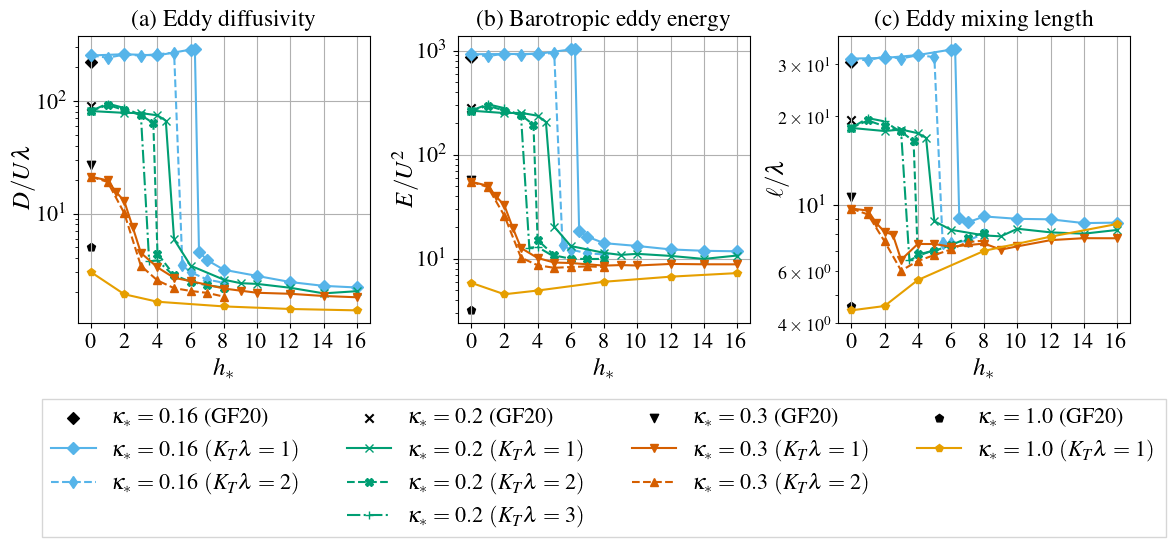

In [52]:
fig, axs = plt.subplots(figsize = (12, 4.25), nrows = 1, ncols = 3)
fig.tight_layout(pad = 4.0)
fontsize = 16

Ld = 15e3
Kd = 1 / Ld
U0 = 0.01
tave_start = 350

# GF scaling constants
c1 = 3.2
c2 = 0.36
c3 = 2.45
c4 = 1.55

### Panel (a)
ax = axs[0]

### kappa* = 0.16 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')
    
D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k16]
D[3] = expt_dict[names_k16[3]].D.mean('t') / (U0 * Ld)
D[4] = expt_dict[names_k16[4]].D.mean('t') / (U0 * Ld)
hstar = np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
D1_16, = ax.plot(hstar, D, color = def_colours[-1], marker = 'D', linestyle = '-', label = r'$\kappa_* = 0.15$ $(K_T \lambda = 1)$')

D = [expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k16_kt50]
D[5] = expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).D.mean('t') / (U0 * Ld)
hstar = np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
D2_16, = ax.plot(hstar, D, color = def_colours[-1], marker = 'd', linestyle = '--', label = r'$\kappa_* = 0.15$ $((K_T \lambda = 2))$')

### kappa* = 0.2 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2]
D[4] = (expt_dict[names_k2[4]].D.sel(t = slice(530 * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item()
hstar = np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
D1_2, = ax.plot(hstar, D, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')

D = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2_kt50]
hstar = np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
D2_2, = ax.plot(hstar, D, color = def_colours[1], marker = 'X', linestyle = '--', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')

D = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2_kt75]
D[5] = (expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item()
hstar = np.array([0., 1., 2., 3., 3.5, 4., 5.])
D3_2, = ax.plot(hstar, D, color = def_colours[1], marker = '+', linestyle = '-.', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')
    
### kappa* = 0.3 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3]
hstar = np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
D1_3, = ax.plot(hstar, D, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')

D = [expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3_kt50]
hstar = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
D2_3, = ax.plot(hstar, D, color = def_colours[4], marker = '^', linestyle = '--', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')

### kappa* = 1.0 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 1.0), color = 'k', marker = 'p', label = r'$\kappa_* = 1.0$ (GF)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k10]
hstar = np.array([0., 2., 4., 8., 12., 16.])
ax.plot(hstar, D, color = def_colours[3], marker = 'p', linestyle = '-',label = r'$\kappa_* = 1.0$ $(K_T \lambda = 1)$')

ax.grid()
ax.set_ylabel(r'$D / U\lambda$', fontsize = fontsize + 2, labelpad = 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(a) Eddy diffusivity', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize)
ax.tick_params(axis='y', which='major', labelsize = fontsize)
ax.set_xticks(ticks = np.arange(0., 18, 2))



### Panel (b)
ax = axs[1]

### kappa* = 0.16 ###

#ax.scatter(0, c4 * np.exp(c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')
ax.scatter(0, c4 * np.exp(2 * c2 / 0.16) / (0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')

E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k16]
E[3] = (expt_dict[names_k16[3]].V ** 2).mean('t') / U0 ** 2
E[4] = (expt_dict[names_k16[4]].V ** 2).mean('t') / U0 ** 2
hstar = np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[-1], marker = 'D', linestyle = '-', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 1)$')

E = [(expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k16_kt50]
E[5] = (expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).V ** 2).mean('t') / U0 ** 2
hstar = np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[-1], marker = 'd', linestyle = '--', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 2)$')

# For legend purposes
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

### kappa* = 0.2 ###

#ax.scatter(0, c4 * np.exp(c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')
ax.scatter(0, c4 * np.exp(2 * c2 / 0.2) / (0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

E = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2])
E[4] = (expt_dict[names_k2[4]].sel(t = slice(530 * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2
hstar = np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')

E = np.array([(expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2_kt50])
hstar = np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[1], marker = 'X', linestyle = '--', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')

E = np.array([(expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2_kt75])
E[5] = (expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2
hstar = np.array([0., 1., 2., 3., 3.5, 4., 5.])
ax.plot(hstar, E, color = def_colours[1], marker = '+', linestyle = '-.', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')

### kappa* = 0.3 ###

#ax.scatter(0, c4 * np.exp(c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')
ax.scatter(0, c4 * np.exp(2 * c2 / 0.3) / (0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

E = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k3])
hstar = np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')

E = np.array([(expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k3_kt50])
hstar = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[4], marker = '^', linestyle = '--', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')

# For legend purposes
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

### kappa* = 1.0 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 1.0) / (1.0), color = 'k', marker = 'p', label = r'$\kappa_* = 1.0$ (GF20)')

E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0**2 for name in names_k10]
hstar = np.array([0., 2., 4., 8., 12., 16.])
ax.plot(hstar, E, color = def_colours[3], marker = 'p', linestyle = '-',label = r'$\kappa_* = 1.0$ $(K_T \lambda = 1)$')

# For legend purposes
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

# For legend purposes
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

ax.grid()
ax.set_ylabel(r'$E / U^2$', fontsize = fontsize + 2, labelpad = 0)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(b) Barotropic eddy energy', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize)
ax.tick_params(axis='y', which='major', labelsize = fontsize)
ax.set_xticks(ticks = np.arange(0., 18, 2))



### Panel (c)
ax = axs[2]

### kappa* = 0.16 ###

ax.scatter(0, c1 * np.exp(c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF)')
    
L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k16]
L[3] = expt_dict[names_k16[3]].Lmix.mean('t') / Ld
L[4] = expt_dict[names_k16[4]].Lmix.mean('t') / Ld
hstar = np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
ax.plot(hstar, L, color = def_colours[-1], marker = 'D',  linestyle = '-', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 1)$')

L = [expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k16_kt50]
L[5] = expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).Lmix.mean('t') / Ld
hstar = np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
ax.plot(hstar, L, color = def_colours[-1], marker = 'd', linestyle = '--', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 2)$')

### kappa* = 0.2 ###

ax.scatter(0, c1 * np.exp(c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF)')

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2]
L[4] = expt_dict[names_k2[4]].sel(t = slice(530 * Ld / U0, None)).Lmix.mean('t') / (Ld) 
hstar = np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, L, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')

L = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2_kt50]
hstar = np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
ax.plot(hstar, L, color = def_colours[1], marker = 'X', linestyle = '--', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')

L = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2_kt75]
L[5] = expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).Lmix.mean('t') / (Ld) 
hstar = np.array([0., 1., 2., 3., 3.5, 4., 5.])
ax.plot(hstar, L, color = def_colours[1], marker = '+', linestyle = '-.', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')
    
### kappa* = 0.3 ###

ax.scatter(0, c1 * np.exp(c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF)')

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k3]
hstar = np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, L, color = def_colours[4], marker = 'v', linestyle = '-',label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')

L = [expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k3_kt50]
hstar = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
ax.plot(hstar, L, color = def_colours[4], marker = '^', linestyle = '--', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')


### kappa* = 1.0 ###

ax.scatter(0, c1 * np.exp(c2 / 1.0), color = 'k', marker = 'p', label = r'$\kappa_* = 1.0$ (GF)')

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k10]
hstar = np.array([0., 2., 4., 8., 12., 16.])
ax.plot(hstar, L, color = def_colours[3], marker = 'p', linestyle = '-',label = r'$\kappa_* = 1.0$ $(K_T \lambda = 1)$')

ax.grid()
ax.set_ylabel(r'$ \ell / \lambda$', fontsize = fontsize + 2, labelpad = -8)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(c) Eddy mixing length', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize)
ax.tick_params(axis='y', which='major', labelsize = fontsize)
ax.tick_params(axis='y', which='minor', labelsize = fontsize - 3)
ax.set_xticks(ticks = np.arange(0., 18, 2))

# Add legend below middle subplot
axs[1].legend(loc = 'upper center', bbox_to_anchor = (0.50, -0.225), fancybox = False, shadow = False, ncol = 4, fontsize = fontsize)

plt.subplots_adjust(wspace = 0.3)
plt.savefig('eddy_scales_monoscale.pdf', dpi=500, bbox_inches='tight')

### PV snapshots

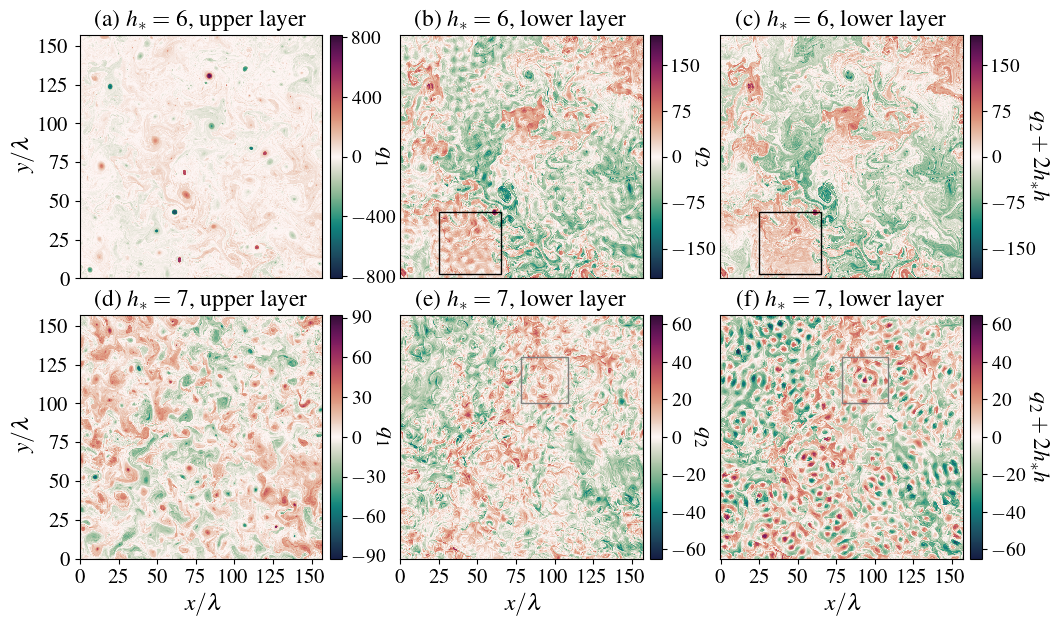

In [25]:
fig, axs = plt.subplots(figsize = (10.4, 6.2), nrows = 2, ncols = 3, sharey = True, sharex = True)
fig.tight_layout(pad = 2.5)
fontsize = 16

cmap = cm.cm.curl

f0 = 1e-4
H0 = 4e3

### panels (a) and (b) and (c)

name = 'kappa016_kt50_h6'

ds = expt_dict[name].isel(x = slice(0, 1024), y = slice(0, 1024))
q = ds.q.isel(t = 0) * Ld / U0
q1 = q.isel(lev = 0)
q2 = q.isel(lev = 1)
x = q.x
y = q.y
h = ds.htop
eta = f0 / H0 * h * Ld / U0

ax = axs[0, 0]

q1max = np.max(q1.values)
q1min = np.min(q1.values)
vmax = np.max([q1max, -q1min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q1, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-1200, 1200, 7), pad = 0.025)
cbar.set_label(r'$q_1$', fontsize = fontsize + 1, rotation = -90, labelpad = 0)
cbar.ax.tick_params(labelsize = fontsize - 2)
ax.set_title(r'(a) $h_* = 6$, upper layer', fontsize = fontsize + 1, pad = 6.5)
ax.set_ylabel('$y / \lambda$', fontsize = fontsize + 1)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize - 1)
ax.tick_params(axis = 'x', which = 'both', length = 0)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

ax = axs[0, 1]

q2max = np.max(q2.values)
q2min = np.min(q2.values)
vmax = np.max([q2max, -q2min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q2, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-150, 150, 5), pad = 0.025)
cbar.set_label(r'$q_2$', fontsize = fontsize + 1, rotation = -90, labelpad = 0)
cbar.ax.tick_params(labelsize = fontsize - 2)
ax.set_title(r'(b) $h_* = 6$, lower layer', fontsize = fontsize + 1, pad = 6.5)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize - 1)
ax.tick_params(axis = 'x', which = 'both', length = 0)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((25, 3), 40, 40, linewidth = 1, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

ax = axs[0, 2]

im = ax.pcolormesh(x / Ld, y / Ld, q2 + 2 * eta, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-150, 150, 5), pad = 0.025)
cbar.set_label(r'$q_2 + 2 h_* h$', fontsize = fontsize + 1, rotation = -90, labelpad = 10)
cbar.ax.tick_params(labelsize = fontsize - 2)
ax.set_title('(c) $h_* = 6$, lower layer', fontsize = fontsize + 1, pad = 6.5)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize - 1)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.tick_params(axis = 'x', which = 'both', length = 0)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((25, 3), 40, 40, linewidth = 1, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

### panels (d) and (e) and (f)

name = 'kappa016_kt50_h7'

ds = expt_dict[name].isel(x = slice(0, 1024), y = slice(0, 1024))
q = ds.q.isel(t = -50) * Ld / U0
q1 = q.isel(lev = 0)
q2 = q.isel(lev = 1)
x = q.x
y = q.y
h = ds.htop
eta = f0 / H0 * h * Ld / U0

ax = axs[1, 0]

q1max = np.max(q1.values)
q1min = np.min(q1.values)
vmax = np.max([q1max, -q1min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q1, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-90, 90, 7), pad = 0.025)
cbar.ax.tick_params(labelsize = fontsize - 2)
cbar.set_label(r'$q_1$', fontsize = fontsize + 1, rotation = -90, labelpad = 8)
ax.set_title(r'(d) $h_* = 7$, upper layer', fontsize = fontsize + 1, pad = 6.5)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize + 1)
ax.set_ylabel('$y / \lambda$', fontsize = fontsize + 1)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize - 1)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

ax = axs[1, 1]

q2max = np.max(q2.values)
q2min = np.min(q2.values)
vmax = 65
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q2, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-60, 60, 7), pad = 0.025)
cbar.ax.tick_params(labelsize = fontsize - 2)
cbar.set_label(r'$q_2$', fontsize = fontsize + 1, rotation = -90, labelpad = 6)
ax.set_title(r'(e) $h_* = 7$, lower layer', fontsize = fontsize + 1, pad = 6.5)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize + 1)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

# rect = patches.Rectangle((37, 44), 40, 40, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
# ax.add_patch(rect)

rect = patches.Rectangle((78.5, 100), 30, 30, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

ax = axs[1, 2]

im = ax.pcolormesh(x / Ld, y / Ld, q2 + 2 * eta, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-60, 60, 7), pad = 0.025)
cbar.set_label(r'$q_2 + 2 h_* h$', fontsize = fontsize + 1, rotation = -90, labelpad = 17)
cbar.ax.tick_params(labelsize = fontsize - 2)
ax.set_title('(f) $h_* = 7$, lower layer', fontsize = fontsize + 1, pad = 6.5)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize + 1)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(axis = 'both', which='major', labelsize = fontsize - 1)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

# rect = patches.Rectangle((37, 44), 40, 40, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
# ax.add_patch(rect)

rect = patches.Rectangle((78.5, 100), 30, 30, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

plt.subplots_adjust(wspace = 0.09, hspace = 0.15)
plt.savefig('PV_snapshots_monoscale.png', dpi = 500, bbox_inches = 'tight')

### Stream function

In [6]:
nx = 2048
ny = nx
nk = nx
nl = ny
nz = 2
Ld = 15e3
ld = 2 * np.pi * Ld
L = 50 * ld
f = 1e-4
beta = 0.
delta = 1

F1 = Ld ** -2 / (1. + delta)
F2 = delta * F1

dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, nx / 2), np.arange(- nx / 2, 0) )
k = np.fft.fftshift(k)
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2

# Stretching matrix
S = np.array([[-F1, F1],
              [F2, -F2]])

a = np.ma.zeros((nz, nz, nl, nk), np.dtype('float64'))
det_inv = np.ma.masked_equal(K2 * (K2 + F1 + F2), 0.) ** -1
a[0,0] = -(K2 + F2) * det_inv
a[0,1] = -F1 * det_inv
a[1,0] = -F2 * det_inv
a[1,1] = -(K2 + F1) * det_inv
a = a.filled(1e20)


def psih_func(a, q):
    '''
    Function for calculating Fourier space stream function from PV field at all times.
    '''
    
    qh = xrft.fft(q, dim = ['x', 'y'], true_phase = False, true_amplitude = False)

    a = xr.DataArray(data = a,
                         dims = ['i', 'lev', 'freq_y', 'freq_x'],
                         coords = dict(
                         freq_x = ('freq_x', qh.freq_x.values),
                         freq_y = ('freq_y', qh.freq_y.values),
                         lev = ('lev', [1, 2]),
                         i = ('i', [1, 2]))
                    )

    psih = xr.dot(a, qh, dims = ['lev']).rename({'i' : 'lev'})
    
    return psih

def psi_func(psih, q):
    '''
    Function for calculating real space stream function from Fourier space stream function at all times.
    '''
        
    psi = xrft.ifft(psih, dim = ['freq_x', 'freq_y'], true_phase = False, true_amplitude = False).real.rename('psi')
    psi = psi.assign_coords(dict(x = ('x', q.x.values), y = ('y', q.y.values)))
    
    return psi

def zeta_func(K2, psih, q):
    '''
    Function for calculating real space vorticity from Fourier space stream function at all times.
    '''
    
    zetah = - K2[np.newaxis, :, :, np.newaxis] * psih
    zeta = xrft.ifft(zetah, dim = ['freq_x', 'freq_y'], true_phase = False, true_amplitude = False).real.rename('zeta')
    zeta = zeta.assign_coords(dict(x = ('x', q.x.values), y = ('y', q.y.values)))
    
    return zeta

def u_func(ll, psih, q):
    '''
    Function for calculating zonal velocity in real space from Fourier space stream funciton function at all times.
    '''
    
    uh = -1j * ll[np.newaxis, :, :, np.newaxis] * psih
    u = xrft.ifft(uh, dim = ['freq_x', 'freq_y'], true_phase = False, true_amplitude = False).real.rename('u')
    u = u.assign_coords(dict(x = ('x', q.x.values), y = ('y', q.y.values)))
    
    return u

def v_func(kk, psih, q):
    '''
    Function for calculating meridional velocity in real space from Fourier space stream funciton function at all times.
    '''
    
    vh = 1j * kk[np.newaxis, :, :, np.newaxis] * psih
    v = xrft.ifft(vh, dim = ['freq_x', 'freq_y'], true_phase = False, true_amplitude = False).real.rename('v')
    v = v.assign_coords(dict(x = ('x', q.x.values), y = ('y', q.y.values)))
    
    return v

Ld = 15e3
U0 = 0.01

In [7]:
name = 'kappa016_kt50_h7'
q_tt = expt_dict[name].sel(t = slice(300 * Ld / U0, None)).q
htop_tt = expt_dict[name].htop
psih_tt = psih_func(a, q_tt)
psi_tt = psi_func(psih_tt, q_tt)
psi_tt_time_mean = psi_tt.mean('t')

/ext3/miniconda3/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


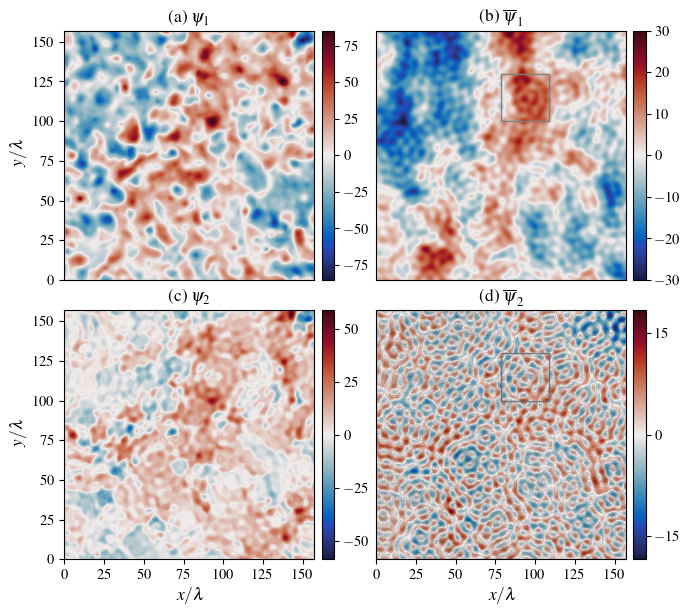

In [24]:
ds = expt_dict['kappa016_kt50_h7'].isel(x = slice(0, 1024), y = slice(0, 1024))
x = ds.x.values
y = ds.y.values
xx, yy = np.meshgrid(x, y)

fig, axs = plt.subplots(figsize = (7.2, 6.25), nrows = 2, ncols = 2, sharey=True, sharex=True)
fig.tight_layout(pad = 2.5)
fontsize = 10.5

cmap = cm.cm.balance

Ld = 15e3
U0 = 0.01

### panels (a) and (b)

ax = axs[0, 0]

psi1 = psi_tt.isel(lev = 0, t = -50).isel(x = slice(0, 1024), y = slice(0, 1024)) / (Ld * U0)
vmax = np.abs(psi1).max()
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, psi1, cmap = cmap, vmin = vmin, vmax = vmax, edgecolor='face')
cbar = plt.colorbar(im, ax = ax, pad = 0.025)
cbar.set_label(r'', fontsize = fontsize, rotation = 0, labelpad = -5)
cbar.ax.tick_params(labelsize = fontsize)
ax.set_title(r'(a) $\psi_1$', fontsize = fontsize + 2, pad = 6.5)
ax.set_ylabel(r'$y / \lambda$', fontsize = fontsize + 2)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
ax.tick_params(axis = 'x', which = 'both', length = 0)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 1)
ax.yaxis.offsetText.set_fontsize(fontsize - 1)

ax = axs[0, 1]

psi1_mean = psi_tt_time_mean.isel(lev = 0).isel(x = slice(0, 1024), y = slice(0, 1024)) / (Ld * U0)
vmax = np.abs(psi1_mean).max()
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, psi1_mean, cmap = cmap, vmin = vmin, vmax = vmax, edgecolor='face')
cbar = plt.colorbar(im, ax = ax, pad = 0.025)
cbar.set_label(r'', fontsize = fontsize, rotation = 0, labelpad = -1)
cbar.ax.tick_params(labelsize = fontsize)
ax.set_title(r'(b) $\overline{\psi}_1$', fontsize = fontsize + 2, pad = 6.5)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.tick_params(axis = 'x', which = 'both', length = 0)
ax.xaxis.offsetText.set_fontsize(fontsize - 1)
ax.yaxis.offsetText.set_fontsize(fontsize - 1)

rect = patches.Rectangle((78.5, 100), 30, 30, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

### panels (c) and (d)

ax = axs[1, 0]

psi2 = psi_tt.isel(lev = 1, t = -50).isel(x = slice(0, 1024), y = slice(0, 1024)) / (Ld * U0)
vmax = np.abs(psi2).max()
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, psi2, cmap = cmap, vmin = vmin, vmax = vmax, edgecolor = 'face')
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-50, 50, 5), pad = 0.025)
cbar.set_label(r'', fontsize = fontsize, rotation = 0, labelpad = 2)
cbar.ax.tick_params(labelsize = fontsize)
ax.set_title(r'(c) $\psi_2$', fontsize = fontsize + 2, pad = 6.5)
ax.set_ylabel('', fontsize = fontsize)
ax.set_xlabel(r'$x / \lambda$', fontsize = fontsize + 2)
ax.set_ylabel(r'$y / \lambda$', fontsize = fontsize + 2)
ax.tick_params(axis='both', which='major', labelsize = fontsize)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 1)
ax.yaxis.offsetText.set_fontsize(fontsize - 1)

ax = axs[1, 1]

psi2_mean = psi_tt_time_mean.isel(lev = 1).isel(x = slice(0, 1024), y = slice(0, 1024)) / (Ld * U0)
vmax = np.abs(psi2_mean).max()
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, psi2_mean, cmap = cmap, vmin = vmin, vmax = vmax, edgecolor = 'face')
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-15, 15, 3), pad = 0.025)
cbar.set_label(r'', fontsize = fontsize, rotation = 0, labelpad = 5)
ax.contour(xx / Ld, yy / Ld, htop_tt.isel(x = slice(0, 1024), y = slice(0, 1024)), colors = 'black', alpha = 0.2, levels = 10, linewidths = 0.5)
cbar.ax.tick_params(labelsize = fontsize)
ax.set_xlabel(r'$x / \lambda$', fontsize = fontsize + 2)
ax.set_title(r'(d) $\overline{\psi}_2$', fontsize = fontsize + 2, pad = 6.5)
ax.tick_params(axis = 'both', which = 'major', labelsize = fontsize)
ax.tick_params(axis = 'y', which = 'both', length = 0)
ax.xaxis.offsetText.set_fontsize(fontsize - 1)
ax.yaxis.offsetText.set_fontsize(fontsize - 1)

rect = patches.Rectangle((78.5, 100), 30, 30, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

plt.subplots_adjust(wspace = 0.03, hspace = 0.12)

plt.savefig('streamfunctions_monoscale.png', dpi=500, bbox_inches='tight')

### Monoscale topography regime transition

In [6]:
def control_parameter(kappa, h):
    
    '''
    Note: both of these scalings, with different scaling constants, work depending on how you view where the transition occurs, especially for kappa = 0.3 where the transition is not as sharp.
    '''
    
    # GF scaling constants
    c1 = 3.2
    c2 = 0.36
    c3 = 2.45
    c4 = 1.55
    mix_eff = 1

    return h / (c3 / (mix_eff * c1) * np.exp(c2 / kappa))

### Calculate control parameter values ###

tave_start = 350
Ld = 15e3
U0 = 0.01
Kd = 1 / Ld

# control parameters

# kappa = 0.16
hstar = [0., 2., 4., 6., 6.25, 6.5, 7., 8., 10., 12., 14., 16.]
control_parameter_k16 = np.array([control_parameter(0.16, h) for h in hstar])

hstar = [1., 2., 3., 4., 5., 5.5, 6., 7., 8.]
control_parameter_k16_kt50 = np.array([control_parameter(0.16, h) for h in hstar])

# kappa = 0.2
hstar = [0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.]
control_parameter_k2 = np.array([control_parameter(0.2, h) for h in hstar])

hstar = [1., 2., 3., 3.75, 4., 5., 6., 7., 8.]
control_parameter_k2_kt50 = np.array([control_parameter(0.2, h) for h in hstar])

hstar = [1., 2., 3., 3.5, 4., 5.]
control_parameter_k2_kt75 = np.array([control_parameter(0.2, h) for h in hstar])

# kappa = 0.3
hstar = [0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.]
control_parameter_k3 = np.array([control_parameter(0.3, h) for h in hstar])

hstar = [1., 2., 3., 4., 5., 6., 7., 8.]
control_parameter_k3_kt50 = np.array([control_parameter(0.3, h) for h in hstar])

# kappa = 1.0
hstar = [0., 2., 4., 8., 12., 16.]
control_parameter_k10 = np.array([control_parameter(1.0, h) for h in hstar])


### Diffusivity ###
D_k16 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k16])
D_k16[3] = (expt_dict[names_k16[3]].D.mean('t') / (U0 * Ld)).values.item() 
D_k16[4] = (expt_dict[names_k16[4]].D.mean('t') / (U0 * Ld)).values.item() 
D_k16_kt50 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k16_kt50])
D_k16_kt50[4] = (expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).D.mean('t') / (U0 * Ld)).values.item()

D_k2 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k2])
D_k2[4] = (expt_dict[names_k2[4]].D.sel(t = slice(530 * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item()
D_k2_kt50 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k2_kt50])
D_k2_kt75 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k2_kt75])
D_k2_kt75[3] = expt_dict[names_k2[3]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)

D_k3 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k3])
D_k3_kt50 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k3_kt50])

D_k10 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k10])

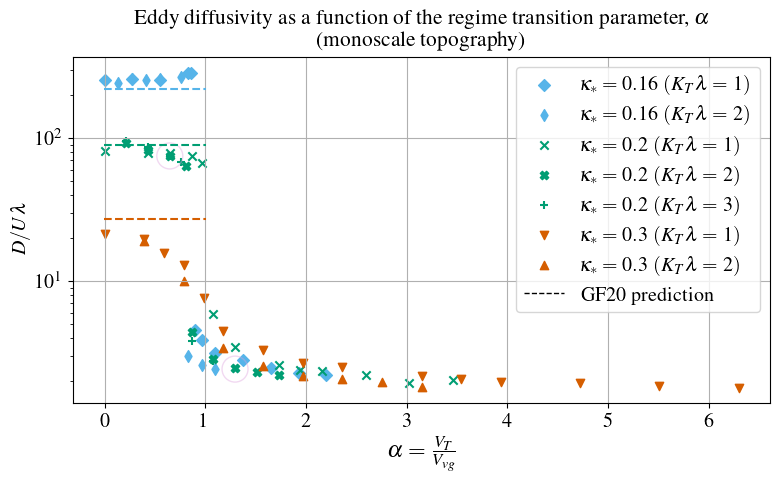

In [10]:
from matplotlib.lines import Line2D

plt.figure(figsize=(9, 4.5))
fontsize = 14.5

# GF scaling constants
c1 = 3.2
c2 = 0.36
c3 = 2.45
c4 = 1.55

plt.axhline(c3 * np.exp(2 * c2 / 0.16), xmin = 0.045, xmax = 0.191, color = def_colours[-1], linestyle = '--')#, label = r'$\kappa_* = 0.16$ (GF20)')
plt.scatter(control_parameter_k16, D_k16, color = def_colours[-1], marker = 'D', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 1)$')
plt.scatter(control_parameter_k16_kt50, D_k16_kt50, color = def_colours[-1], marker = 'd', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 2)$')

plt.axhline(c3 * np.exp(2 * c2 / 0.2), xmin = 0.045, xmax = 0.191, color = def_colours[1], linestyle = '--')#, label = r'$\kappa_* = 0.2$ (GF20)')
plt.scatter(control_parameter_k2, D_k2, color = def_colours[1], marker = 'x', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')
plt.scatter(control_parameter_k2_kt50, D_k2_kt50, color = def_colours[1], marker = 'X', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')
plt.scatter(control_parameter_k2_kt75, D_k2_kt75, color = def_colours[1], marker = '+', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')

plt.axhline(c3 * np.exp(2 * c2 / 0.3), xmin = 0.045, xmax = 0.191, color = def_colours[4], linestyle = '--')#, label = r'$\kappa_* = 0.3$ (GF20)')
plt.scatter(control_parameter_k3, D_k3, color = def_colours[4], marker = 'v', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')
plt.scatter(control_parameter_k3_kt50, D_k3_kt50, color = def_colours[4], marker = '^', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')

# plt.axhline(c3 * np.exp(2 * c2 / 1.0), xmin = 0.047, xmax = 0.162, color = def_colours[3], linestyle = '--', label = r'$\kappa_* = 1.0$ (GF20)')
# plt.scatter(control_parameter_k10[:-2], D_k10[:-2], color = def_colours[3], marker = 'p', label = r'$\kappa_* = 1.0$ $(K_T \lambda = 1)$')

# handles for legend
handles, labels = plt.gca().get_legend_handles_labels()
line, label = Line2D([], [], color = 'k', lw = 1, linestyle = '--'), 'GF20 prediction'
handles.append(line) 
labels.append(label) 
plt.legend(handles = handles, labels = labels, fontsize = fontsize)

plt.scatter(control_parameter(0.2, 3), (expt_dict['kappa02_kt50_h3'].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).item(),
            s = 350, facecolors = 'none', edgecolor = 'plum', alpha = 0.4)
plt.scatter(control_parameter(0.2, 6), (expt_dict['kappa02_kt50_h6'].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).item() - 0.05,
            s = 350, facecolors = 'none', edgecolor = 'plum', alpha = 0.4)

plt.grid()
plt.ylabel(r'$D / U \lambda$', fontsize = fontsize)
plt.xlabel(r'$\alpha = \frac{V_T}{V_{vg}}$', fontsize = fontsize + 2)
plt.xticks(ticks = np.linspace(0., 6, 7), fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.yscale('log')
plt.title('Eddy diffusivity as a function of the regime transition parameter, $\\alpha$ \n (monoscale topography)', fontsize = fontsize + 1, pad = 7.5)
#plt.savefig('regime_transition_monoscale.pdf', dpi = 300, bbox_inches = 'tight')

### Monoscale topography energy budget

In [63]:
path = '/scratch/mp6191/GeophysicalFlows_expts'
expts = ['/kappa02_notopo', '/kappa02_kt25_h4', '/kappa02_kt50_h3', '/kappa02_kt25_h6', '/kappa02_kt50_h6', '/kappa02_kt75_h6']
names = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '_energy_budget.nc' for expt in expts]

# Import simulations
#expt_dict = dict()
for i in range(len(expts)):
    name = names[i]
    ds = xr.open_dataset(paths[i])
    expt_dict[name] = ds

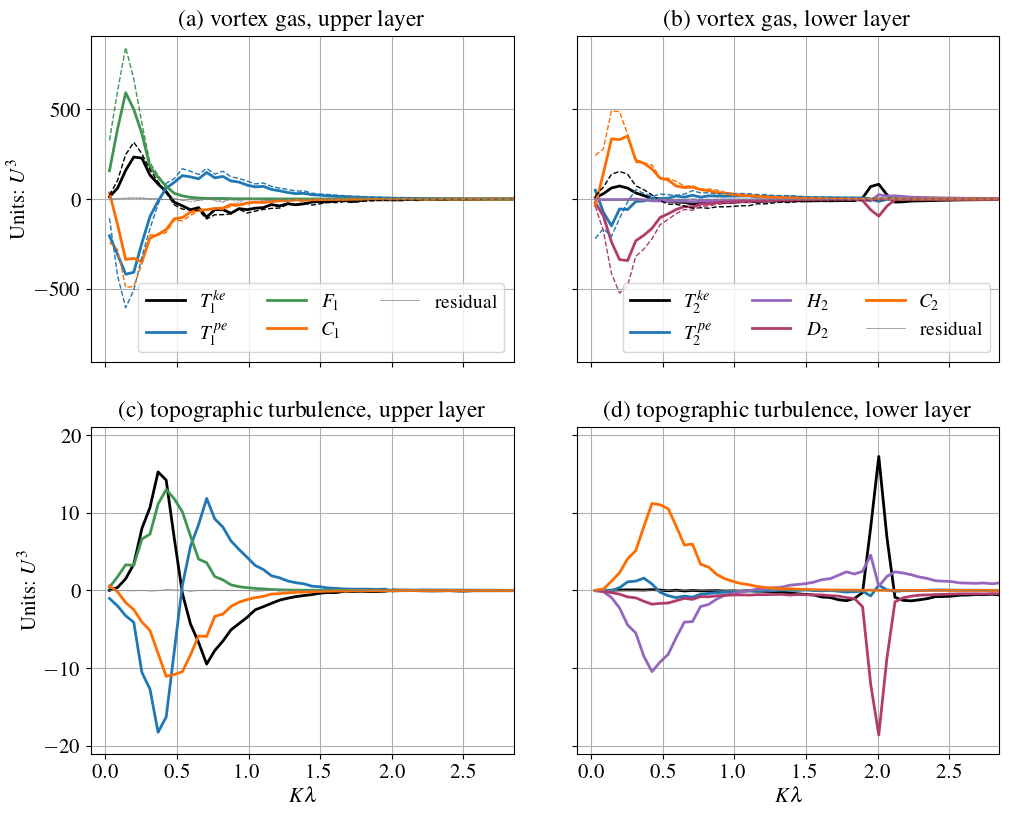

In [69]:
fig, axs = plt.subplots(figsize = (10, 8), nrows = 2, ncols = 2, sharex=True, sharey='row')
fig.tight_layout(pad = 2.0)
fontsize = 15
linewidth = 2.

cmap_1 = sns.color_palette(palette='gist_earth')
cmap_2 = sns.color_palette(palette='flare')
cmap_3 = sns.color_palette(palette='gist_heat')
cmap_4 = sns.color_palette(palette='gnuplot')

KeFlux_colour = 'k'
PeFlux_colour = sns.color_palette(palette='tab10')[0] #cmap_1[0]
ForceFlux_colour = cmap_1[2]
ExchangeFlux_colour = cmap_3[4]
DragFlux_colour = cmap_2[3]
TopoFlux_colour = sns.color_palette(palette='tab10')[4] #cmap_4[0]

Ld = 15e3
L = 2*np.pi * 25 * Ld
U0 = 0.01
Kd = 1 / Ld
Kmax = 300
K = (ds.K * Ld).sel(K = slice(None, Kmax))
dK = K[1].values - K[0].values

### panels (a) and (b) ###

name = 'kappa02_kt50_h3'
ds = expt_dict[name]
h = ds.htop.values
hrms = np.sqrt(np.mean(h ** 2))
hh = np.fft.fftn(h, axes = (-2, -1))
Kr, h_spec = isotropic_spec(np.abs(hh) ** 2 / hrms ** 2)

# Layer 1
ax = axs[0, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$T^{ke}_1$', color = KeFlux_colour, linewidth = linewidth)

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$T^{pe}_1$', color = PeFlux_colour, linewidth = linewidth)

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size]  / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = linewidth)

ExchangeFlux1 = -np.diff(Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size]  / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = linewidth)

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size]  / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'', fontsize = fontsize)
ax.set_ylabel(r'Units: $U^3$', fontsize = fontsize)
ax.grid()
ax.set_ylim([-910, 910])
ax.legend(loc = 'lower right', fontsize = fontsize- 1, ncol = 3)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(a) vortex gas, upper layer', fontsize = fontsize + 2, pad = 7.5)


# Layer 2
ax = axs[0, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$T^{ke}_2$', color = KeFlux_colour, linewidth = linewidth)

APEFlux2 = -np.diff(Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$T^{pe}_2$', color = PeFlux_colour, linewidth = linewidth)

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$H_2$', color = TopoFlux_colour, linewidth = linewidth)

DragFlux2 =  -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = linewidth)

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = linewidth)

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'', fontsize = fontsize)
ax.set_ylabel(r'', fontsize = fontsize)
ax.grid()
ax.set_ylim([-910, 910])
ax.legend(loc = 'lower right', fontsize = fontsize - 1, ncol = 3)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(b) vortex gas, lower layer', fontsize = fontsize + 2, pad = 7.5)


### panels (a) and (b) ###

name = 'kappa02_notopo'
ds = expt_dict[name]

# Layer 1
ax = axs[0, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$T^{ke}_1$', color = KeFlux_colour, linewidth = 1, linestyle = '--')

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$T^{pe}_1$', color = PeFlux_colour, linewidth = 1, linestyle = '--')

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size] / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = 1, linestyle = '--')

ExchangeFlux1 = -np.diff(Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size] / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = 1, linestyle = '--')

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5, linestyle = '--')


# Layer 2
ax = axs[0, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$T^{ke}_2$', color = KeFlux_colour, linewidth = 1, linestyle = '--')

APEFlux2 =-np.diff( Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$T^{pe}_2$', color = PeFlux_colour, linewidth = 1, linestyle = '--')

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$H_2$', color = TopoFlux_colour, linewidth = 1, linestyle = '--')

DragFlux2 =  -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = 1, linestyle = '--')

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = 1, linestyle = '--')

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5, linestyle = '--')

### panels (c) and (d) ###

name = 'kappa02_kt50_h6'
ds = expt_dict[name]

# Layer 1
ax = axs[1, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$\Pi^{ke}_1$', color = KeFlux_colour, linewidth = linewidth)

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$\Pi^{pe}_1$', color = PeFlux_colour, linewidth = linewidth)

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size] / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = linewidth)

ExchangeFlux1 =-np.diff( Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size] / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = linewidth)

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'$K \lambda$', fontsize = fontsize)
ax.set_ylabel(r'Units: $U^3$', fontsize = fontsize)
ax.grid()
ax.set_ylim([-21, 21])
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(c) topographic turbulence, upper layer', fontsize = fontsize + 2, pad = 7.5)


# Layer 2
ax = axs[1, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$\Pi^{ke}_2$', color = KeFlux_colour, linewidth = linewidth)

APEFlux2 = -np.diff(Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$\Pi^{pe}_2$', color = PeFlux_colour, linewidth = linewidth)

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$T_2$', color = TopoFlux_colour, linewidth = linewidth)

DragFlux2 =  -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = linewidth)

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = linewidth)

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'$K \lambda$', fontsize = fontsize)
ax.set_ylabel(r'', fontsize = fontsize)
ax.grid()
ax.set_ylim([-21, 21])
ax.set_xlim([-0.1, 2.85])
#ax.set_xscale('log')
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(d) topographic turbulence, lower layer', fontsize = fontsize + 2, pad = 7.5)

plt.subplots_adjust(wspace = 0.15, hspace = 0.2)

plt.savefig('energy_budgets_monoscale.pdf', dpi=500, bbox_inches='tight')

### Goff Jordan topography

In [6]:
def GJ_topography(h_star, seed):
             
    # Parameters
    mu = 3.5
    k0 = 1.8e-4
    l0 = 1.8e-4
    
    # Topographic spectrum
    htopspec = 2 * np.pi * (mu - 2) / (k0 * l0) * (1 + (kk / k0) ** 2 + (ll / l0) ** 2) ** (-mu / 2)
    np.random.seed(seed)
    htoph = htopspec * np.exp(2 * np.pi * 1j * np.random.randn(N, N))

    # Recover htop from htoph                                                                                                                                              
    htop = np.real(np.fft.ifftn(htoph, axes = (-2, -1)))
    
    # Get peak in topographic spectrum for calculating h_*
    Kr, htoph_iso = isotropic_spec(np.abs(htoph) ** 2)
    Ktopo = Kr[np.argmax(htoph_iso)]
    
    # Get hrms for given h_*, and scale h
    hrms = h_star * U0 * H0 * Ktopo / f0
    c = hrms / np.sqrt(np.mean(htop ** 2))
    htop = c * htop
    
    return htop

In [59]:
# Import L50 runs
path = '/scratch/mp6191/GeophysicalFlows_expts/ReviewRuns'
expts = ['/kappa016_GJ_h3', '/kappa016_GJ_h6', '/kappa016_GJ_h8', '/kappa016_GJ_h9', '/kappa016_GJ_h10', '/kappa016_GJ_h12', '/kappa016_GJ_h16',
         '/kappa02_GJ_h4', '/kappa02_GJ_h6', '/kappa02_GJ_h6.5', '/kappa02_GJ_h7', '/kappa02_GJ_h8', '/kappa02_GJ_h12', '/kappa02_GJ_h16',
         '/kappa03_GJ_h2', '/kappa03_GJ_h3', '/kappa03_GJ_h4', '/kappa03_GJ_h6', '/kappa03_GJ_h8', '/kappa03_GJ_h12', '/kappa03_GJ_h16']
names = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names[i]
    ds = xr.open_dataset(path + expts[i] + '/output' + expts[i] + '.nc')
    expt_dict[name] = ds

expt_dict['kappa02_notopo'] = xr.open_dataset('/scratch/mp6191/GeophysicalFlows_expts/kappa02_notopo/output/kappa02_notopo.nc')

names_k16_GJ = ['kappa016_notopo', 'kappa016_GJ_h3', 'kappa016_GJ_h6', 'kappa016_GJ_h8', 'kappa016_GJ_h9', 'kappa016_GJ_h10', 'kappa016_GJ_h12', 'kappa016_GJ_h16']
names_k2_GJ = ['kappa02_notopo', 'kappa02_GJ_h4', 'kappa02_GJ_h6', 'kappa02_GJ_h6.5', 'kappa02_GJ_h7', 'kappa02_GJ_h8', 'kappa02_GJ_h12', 'kappa02_GJ_h16']
names_k3_GJ = ['kappa03_notopo', 'kappa03_GJ_h2', 'kappa03_GJ_h3', 'kappa03_GJ_h4', 'kappa03_GJ_h6', 'kappa03_GJ_h8', 'kappa03_GJ_h12', 'kappa03_GJ_h16']

In [60]:
### Parameters ###

Ld = 15e3
kd = 1 / Ld
ld = 2 * np.pi / kd
L = 25 * ld
N = 1024
x = np.linspace(0., L, N)
y = np.linspace(0., L, N)
xx, yy = np.meshgrid(x, y)
    
# Define horizontal structure of PV
dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2
K = np.sqrt(K2)

f0 = 1e-4
U0 = 0.01
H0 = 4000.
Ktopo = 1 * kd
hstar = 5
hrms = H0 * Ktopo * H0 * hstar / f0

### Import topography from one of my simulations ###

ds = expt_dict['kappa02_GJ_h4']
h = 5/4 * ds.htop.values
hrms = np.sqrt(np.mean(h ** 2))
hh = np.fft.fftn(h, axes = (-2, -1))
Kr, h_spec = isotropic_spec(np.abs(hh) ** 2 / hrms ** 2)
h = 5 / (f0 * hrms / (U0 * H0 * Kr[np.argmax(h_spec)])) * h

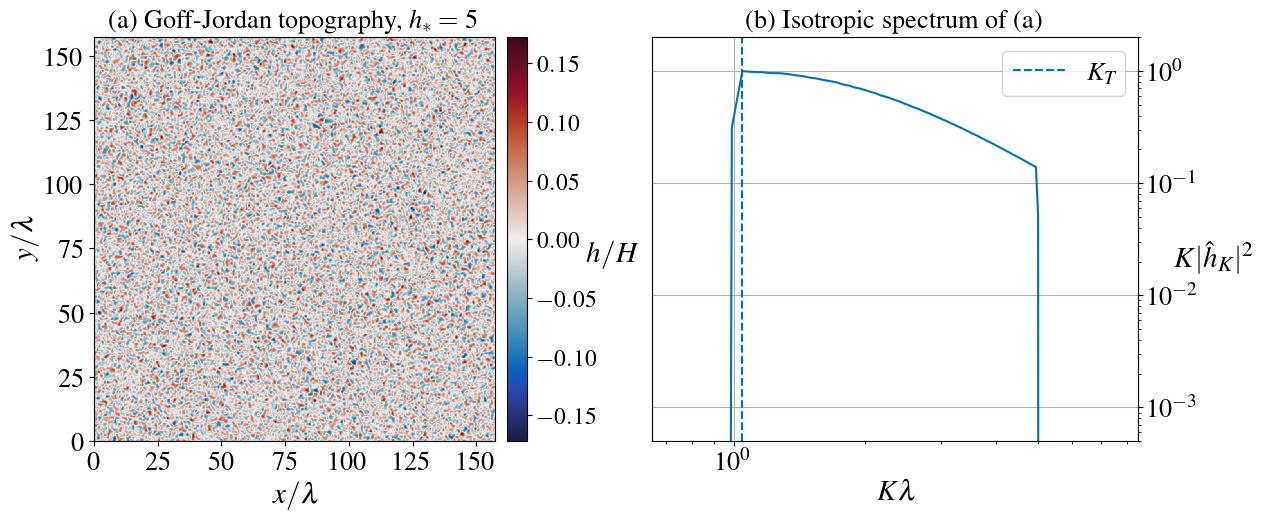

In [61]:
fig, axs = plt.subplots(figsize = (11.5, 5), nrows = 1, ncols = 2)
fig.tight_layout(pad = 2.5)
fontsize = 19

### Panel (a)
ax = axs[0]
pmesh = ax.pcolormesh(xx / Ld, yy / Ld, h / H0, vmin = -np.abs(h / H0).max(), vmax = np.abs(h / H0).max(), cmap = cm.cm.balance)
cbar = plt.colorbar(pmesh, pad = 0.025)
cbar.ax.tick_params(labelsize = fontsize - 2)

ax.set_xlabel(r'$x / \lambda$', fontsize = fontsize + 2)
ax.set_ylabel(r'$y / \lambda$', fontsize = fontsize + 2)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
cbar.set_label(r'$h / H$', rotation = 0, fontsize = fontsize + 2, labelpad = 10)
cbar.ax.tick_params(labelsize = fontsize - 2)
ax.set_title('(a) Goff-Jordan topography, $h_* = 5$', fontsize = fontsize, pad = 7.5)

### Panel (b)
ax = axs[1]
imin = 0
imax = -1
ymin = 5e-4
ymax = 2
ax.plot(Kr[imin:imax] * Ld, h_spec[imin:imax] / np.max(h_spec[imin:imax]), '-', color = def_colours[0])
ax.vlines(Kr[np.argmax(h_spec)] * Ld, ymin, ymax, colors = def_colours[0], linestyles = '--', label = r'$K_T$')

ax.set_xlabel(r'$K\lambda$', fontsize = fontsize + 2)
ax.set_ylabel(r'$K|\hat{h}_{K}|^2$', rotation = 0, fontsize = fontsize + 2, labelpad = 10)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_title('(b) Isotropic spectrum of (a)', fontsize = fontsize, pad = 7.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([ymin, ymax])
ax.set_xlim([0.65, 8.5])
ax.grid()
ax.legend(fontsize = fontsize)

plt.subplots_adjust(wspace = 0.15)

plt.savefig('GJ_topography.png', dpi=500, bbox_inches='tight')

### Goff Jordan topography eddy scale sweep

In [10]:
Ld = 15e3
U0 = 0.01
f0 = 1e-4
H0 = 4e3

def topographic_velocity_k16(h):

    Ld = 15e3
    kd = 1 / Ld
    ld = 2 * np.pi / kd
    L = 50 * ld
    N = 2048
    x = np.linspace(0., L, N)
    y = np.linspace(0., L, N)
    xx, yy = np.meshgrid(x, y)
    
    dk = 2 * np.pi / L
    k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
    l = k
    kk, ll = np.meshgrid(k, l)
    K2 = kk ** 2 + ll ** 2
    KK = np.sqrt(K2)
    
    eta = f0 / H0 * h
    etah = np.fft.fftn(eta, axes=(-2, -1))
    
    psiTh = etah / K2
    psiTh[0,0] = 0
    psiT = np.real(np.fft.ifftn(psiTh, axes = (-2, -1)))
    
    dpsiTdx = np.real(np.fft.ifftn(1j * kk * psiTh, axes = (-2, -1)))
    dpsiTdy = np.real(np.fft.ifftn(1j * ll * psiTh, axes = (-2, -1)))
    
    E_T = 0.5 * np.mean(dpsiTdx ** 2 + dpsiTdy ** 2)
    V_T = np.sqrt(2 * E_T)
    
    return V_T

def topographic_velocity(h):

    Ld = 15e3
    kd = 1 / Ld
    ld = 2 * np.pi / kd
    L = 25 * ld
    N = 1024
    x = np.linspace(0., L, N)
    y = np.linspace(0., L, N)
    xx, yy = np.meshgrid(x, y)
    
    dk = 2 * np.pi / L
    k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
    l = k
    kk, ll = np.meshgrid(k, l)
    K2 = kk ** 2 + ll ** 2
    KK = np.sqrt(K2)
    
    eta = f0 / H0 * h
    etah = np.fft.fftn(eta, axes=(-2, -1))
    
    psiTh = etah / K2
    psiTh[0,0] = 0
    psiT = np.real(np.fft.ifftn(psiTh, axes = (-2, -1)))
    
    dpsiTdx = np.real(np.fft.ifftn(1j * kk * psiTh, axes = (-2, -1)))
    dpsiTdy = np.real(np.fft.ifftn(1j * ll * psiTh, axes = (-2, -1)))
    
    E_T = 0.5 * np.mean(dpsiTdx ** 2 + dpsiTdy ** 2)
    V_T = np.sqrt(2 * E_T)
    
    return V_T

def control_parameter(kappa, h):
    
    '''
    Note: both of these scalings, with different scaling constants, work depending on how you view where the transition occurs, especially for kappa = 0.3 where the transition is not as sharp.
    '''
    
    # GF scaling constants
    c1 = 3.2
    c2 = 0.36
    c3 = 2.45
    c4 = 1.55
    mix_eff = 1 #0.3

    D_vg = c3 * np.exp(2 * c2 / kappa)
    l_vg = c1 * np.exp(c2 / kappa)
    V_vg = D_vg / (mix_eff * l_vg)

    if kappa == 0.16:
        V_T = topographic_velocity_k16(h) / U0
    else:
        V_T = topographic_velocity(h) / U0

    return V_T / V_vg

In [11]:
tave_start = 335

# control parameters

# Convert hstar to hstar with KT_max definition
control_parameter_k16_GJ = np.array([control_parameter(0.16, expt_dict[name].htop) for name in names_k16_GJ])
control_parameter_k2_GJ = np.array([control_parameter(0.2, expt_dict[name].htop) for name in names_k2_GJ])
control_parameter_k3_GJ = np.array([control_parameter(0.3, expt_dict[name].htop) for name in names_k3_GJ])


### Diffusivity ###
D_k16_GJ = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k16_GJ])
D_k2_GJ = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k2_GJ])
D_k3_GJ = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).values.item() for name in names_k3_GJ])

hstar_k16 = np.array([0., 3., 6., 8., 9., 10., 12., 16.])
hstar_k2 = np.array([0., 4., 6., 6.5, 7., 8., 12., 16.])
hstar_k3 = np.array([0., 2., 3., 4., 6., 8., 12., 16.])

/state/partition1/job-53166316/ipykernel_332774/1996790350.py:27: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53166316/ipykernel_332774/1996790350.py:27: RuntimeWarning: divide by zero encountered in divide
  psiTh = etah / K2
/state/partition1/job-53166316/ipykernel_332774/1996790350.py:60: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53166316/ipykernel_332774/1996790350.py:60: RuntimeWarning: divide by zero encountered in divide
  psiTh = etah / K2


/state/partition1/job-53166316/ipykernel_332774/3452289512.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
/state/partition1/job-53166316/ipykernel_332774/3452289512.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
/state/partition1/job-53166316/ipykernel_332774/3452289512.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)
/state/partition1/job-53166316/ipykernel_332774/1996790350.py:60: RuntimeWarning: divide

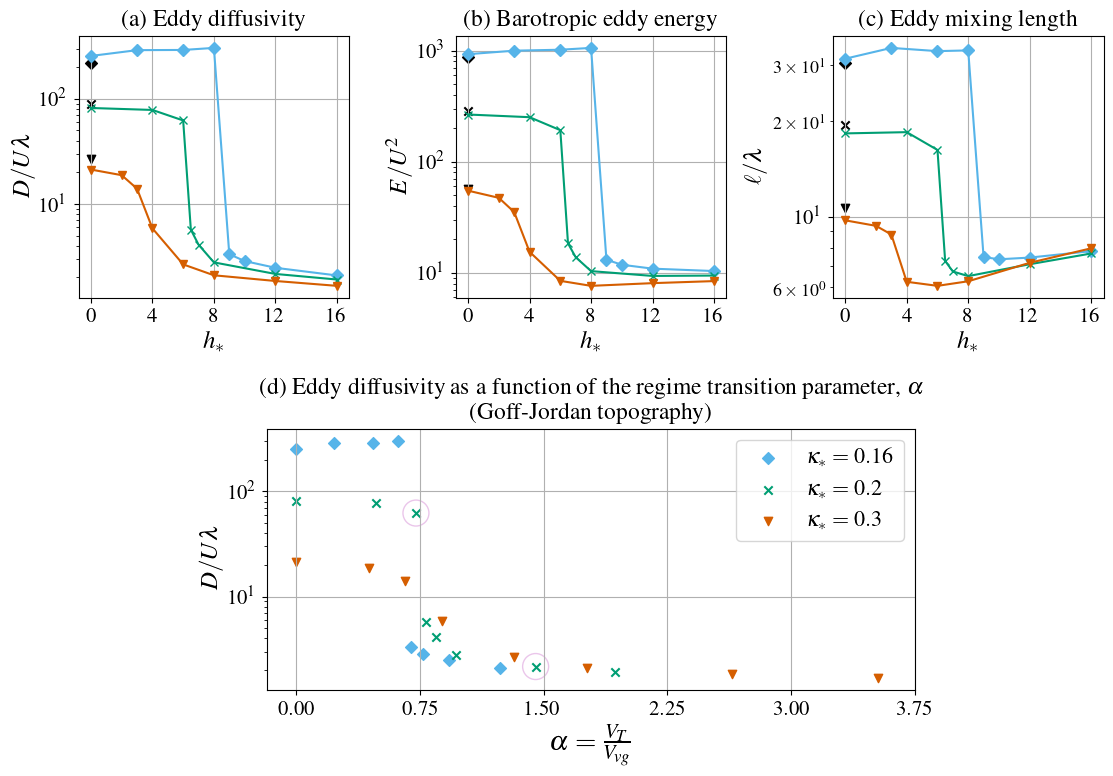

In [29]:
fig, axs = plt.subplots(figsize = (12, 8.2), nrows = 1, ncols = 3)
fig.tight_layout(pad = 5.0)
fontsize = 16

ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)
ax4 = plt.subplot2grid((2, 6), (1, 1), rowspan = 1, colspan = 4)

fig.tight_layout(pad = 5.0)

# GF scaling constants
c1 = 3.2
c2 = 0.36
c3 = 2.45
c4 = 1.55

### Panel (a)
ax = ax1

### kappa* = 0.16 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k16_GJ]
ax.plot(hstar_k16, D, color = def_colours[-1], marker = 'D', linestyle = '-')

### kappa* = 0.2 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2_GJ]
ax.plot(hstar_k2, D, color = def_colours[1], marker = 'x', linestyle = '-')

    
### kappa* = 0.3 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3_GJ]
ax.plot(hstar_k3, D, color = def_colours[4], marker = 'v', linestyle = '-')

ax.grid()
ax.set_ylabel(r'$D / U\lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(a) Eddy diffusivity', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.arange(0., 20, 4))

### Panel (b)
ax = ax2

### kappa* = 0.16 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 0.16) / (0.16), color = 'k', marker = 'D')

E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k16_GJ]
ax.plot(hstar_k16, E, color = def_colours[-1], marker = 'D', linestyle = '-')

### kappa* = 0.2 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 0.2) / (0.2), color = 'k', marker = 'x')

E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2_GJ]
ax.plot(hstar_k2, E, color = def_colours[1], marker = 'x', linestyle = '-')

    
### kappa* = 0.3 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 0.3) / (0.3), color = 'k', marker = 'v')

E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k3_GJ]
ax.plot(hstar_k3, E, color = def_colours[4], marker = 'v', linestyle = '-')

ax.grid()
ax.set_ylabel(r'$E / U^2$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(b) Barotropic eddy energy', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.arange(0., 20, 4))



### Panel (c)
ax = ax3

### kappa* = 0.16 ###

ax.scatter(0, c1 * np.exp(c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')

lmix = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k16_GJ]
ax.plot(hstar_k16, lmix, color = def_colours[-1], marker = 'D', linestyle = '-') # , label = r'$\kappa_* = 0.16$ $(K_T = k_d)$'

### kappa* = 0.2 ###

ax.scatter(0, c1 * np.exp(c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

lmix = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2_GJ]
ax.plot(hstar_k2, lmix, color = def_colours[1], marker = 'x', linestyle = '-') # , label = r'$\kappa_* = 0.2$ $(K_T = k_d)$'

    
### kappa* = 0.3 ###

ax.scatter(0, c1 * np.exp(c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

lmix = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k3_GJ]
ax.plot(hstar_k3, lmix, color = def_colours[4], marker = 'v', linestyle = '-') # , label = r'$\kappa_* = 0.3$ $(K_T = k_d)$')

ax.grid()
ax.set_ylabel(r'$ \ell / \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(c) Eddy mixing length', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='minor', labelsize = fontsize - 3)
ax.set_xticks(ticks = np.arange(0., 20, 4))


### Panel (d)

ax = ax4

ax.scatter(control_parameter_k16_GJ, D_k16_GJ, color = def_colours[-1], marker = 'D', linestyle = '-', label = r'$\kappa_* = 0.16$')
ax.scatter(control_parameter_k2_GJ, D_k2_GJ, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$')
ax.scatter(control_parameter_k3_GJ, D_k3_GJ, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$')

ax.scatter(control_parameter(0.2, expt_dict['kappa02_GJ_h6'].htop), (expt_dict['kappa02_GJ_h6'].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).item(),
            s = 350, facecolors = 'none', edgecolor = 'plum', alpha = 0.6)

ax.scatter(control_parameter(0.2, expt_dict['kappa02_GJ_h12'].htop), (expt_dict['kappa02_GJ_h12'].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t') / (U0 * Ld)).item(),
            s = 350, facecolors = 'none', edgecolor = 'plum', alpha = 0.6)


ax.grid()
ax.set_ylabel(r'$D / U \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\alpha = \frac{V_T}{V_{vg}}$', fontsize = fontsize + 4)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_yscale('log')
ax.set_title('(d) Eddy diffusivity as a function of the regime transition parameter, $\\alpha$ \n (Goff-Jordan topography)', fontsize = fontsize + 1, pad = 7.5)
ax.legend(fontsize = fontsize)
ax.set_xticks(ticks = np.linspace(0., 3.75, 6))

plt.subplots_adjust(wspace = 1.3, hspace = 0.5)

plt.savefig('eddy_scales_GJ.pdf', dpi = 500, bbox_inches='tight')

### Goff Jordan energy budget

In [88]:
path = '/scratch/mp6191/GeophysicalFlows_expts/ReviewRuns'
expts = ['/kappa02_GJ_h6', '/kappa02_GJ_h12']
names = [expt[1:] for expt in expts]
paths = [path + expt + '_EnergyBudget' + '/output' + expt + '_EnergyBudget.nc' for expt in expts]

# Import simulations
#expt_dict = dict()
for i in range(len(expts)):
    name = names[i]
    ds = xr.open_dataset(paths[i])
    expt_dict[name] = ds

expt_dict['kappa02_notopo'] = xr.open_dataset('/scratch/mp6191/GeophysicalFlows_expts/kappa02_notopo/output/kappa02_notopo_energy_budget.nc')

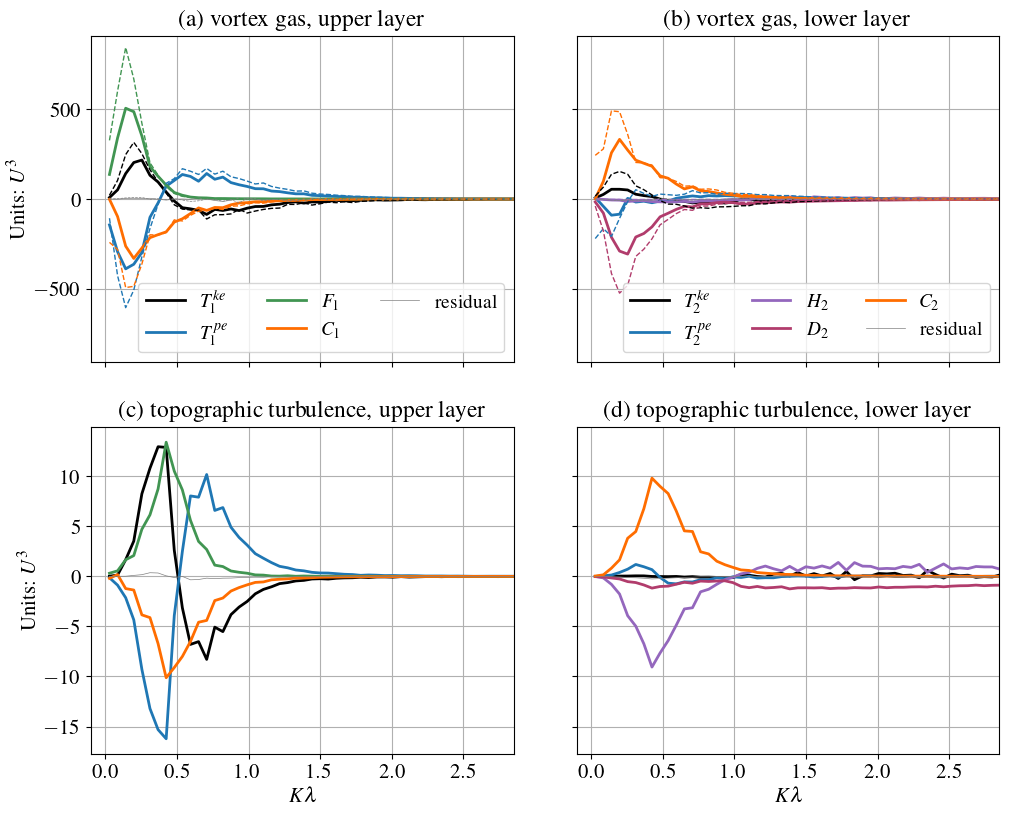

In [89]:
fig, axs = plt.subplots(figsize = (10, 8), nrows = 2, ncols = 2, sharex = True, sharey='row')
fig.tight_layout(pad = 2.0)
fontsize = 15
linewidth = 2

cmap_1 = sns.color_palette(palette='gist_earth')
cmap_2 = sns.color_palette(palette='flare')
cmap_3 = sns.color_palette(palette='gist_heat')
cmap_4 = sns.color_palette(palette='gnuplot')

KeFlux_colour = 'k'
PeFlux_colour = sns.color_palette(palette='tab10')[0]
ForceFlux_colour = cmap_1[2]
ExchangeFlux_colour = cmap_3[4]
DragFlux_colour = cmap_2[3]
TopoFlux_colour = sns.color_palette(palette='tab10')[4]

Ld = 15e3
U0 = 0.01
Kd = 1 / Ld
Kmax = 300
K = (ds.K * Ld).sel(K = slice(None, Kmax))
dK = K[1].values - K[0].values

### panels (a) and (b) ###

name = 'kappa02_GJ_h6'
ds = expt_dict[name]

# Layer 1
ax = axs[0, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$T^{ke}_1$', color = KeFlux_colour, linewidth = linewidth)

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$T^{pe}_1$', color = PeFlux_colour, linewidth = linewidth)

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size] / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = linewidth)

ExchangeFlux1 = -np.diff(Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size] / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = linewidth)

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'', fontsize = fontsize)
ax.set_ylabel(r'Units: $U^3$', fontsize = fontsize)
ax.grid()
ax.set_ylim([-910, 910])
ax.legend(loc = 'lower right', fontsize = fontsize- 1, ncol = 3)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(a) vortex gas, upper layer', fontsize = fontsize + 2, pad = 7.5)


# Layer 2
ax = axs[0, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$T^{ke}_2$', color = KeFlux_colour, linewidth = linewidth)

APEFlux2 = -np.diff(Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$T^{pe}_2$', color = PeFlux_colour, linewidth = linewidth)

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$H_2$', color = TopoFlux_colour, linewidth = linewidth)

DragFlux2 =  -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = linewidth)

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = linewidth)

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'', fontsize = fontsize)
ax.set_ylabel(r'', fontsize = fontsize)
ax.grid()
ax.set_ylim([-910, 910])
ax.legend(loc = 'lower right', fontsize = fontsize - 1, ncol = 3)
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(b) vortex gas, lower layer', fontsize = fontsize + 2, pad = 7.5)

### panels (a) and (b) ###

name = 'kappa02_notopo'
ds = expt_dict[name]

# Layer 1
ax = axs[0, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$T^{ke}_1$', color = KeFlux_colour, linewidth = 1, linestyle = '--')

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$T^{pe}_1$', color = PeFlux_colour, linewidth = 1, linestyle = '--')

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size] / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = 1, linestyle = '--')

ExchangeFlux1 = -np.diff(Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size] / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = 1, linestyle = '--')

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5, linestyle = '--')


# Layer 2
ax = axs[0, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$T^{ke}_2$', color = KeFlux_colour, linewidth = 1, linestyle = '--')

APEFlux2 = -np.diff(Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$T^{pe}_2$', color = PeFlux_colour, linewidth = 1, linestyle = '--')

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$H_2$', color = TopoFlux_colour, linewidth = 1, linestyle = '--')

DragFlux2 = -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = 1, linestyle = '--')

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = 1, linestyle = '--')

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5, linestyle = '--')

### panels (c) and (d) ###

name = 'kappa02_GJ_h12'
ds = expt_dict[name]

# Layer 1
ax = axs[1, 0]

KEFlux1 = -np.diff(Ld / U0**3 * ds.KEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux1[:Kr.size] / dK, label = r'$\Pi^{ke}_1$', color = KeFlux_colour, linewidth = linewidth)

APEFlux1 = -np.diff(Ld / U0**3 * ds.APEFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux1[:Kr.size] / dK, label = r'$\Pi^{pe}_1$', color = PeFlux_colour, linewidth = linewidth)

ShearFlux1 = -np.diff(Ld / U0**3 * ds.ShearFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ShearFlux1[:Kr.size] / dK, label = r'$F_1$', color = ForceFlux_colour, linewidth = linewidth)

ExchangeFlux1 = -np.diff(Ld / U0**3 * ds.ExchangeFlux1.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux1[:Kr.size] / dK, label = r'$C_1$', color = ExchangeFlux_colour, linewidth = linewidth)

residual1 = -(KEFlux1 + APEFlux1 + ShearFlux1 + ExchangeFlux1)
ax.plot(Kr * Ld, residual1[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'$K \lambda$', fontsize = fontsize)
ax.set_ylabel(r'Units: $U^3$', fontsize = fontsize)
ax.grid()
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(c) topographic turbulence, upper layer', fontsize = fontsize + 2, pad = 7.5)

# Layer 2
ax = axs[1, 1]

KEFlux2 = -np.diff(Ld / U0**3 * ds.KEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, KEFlux2[:Kr.size] / dK, label = r'$\Pi^{ke}_2$', color = KeFlux_colour, linewidth = linewidth)

APEFlux2 = -np.diff(Ld / U0**3 * ds.APEFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, APEFlux2[:Kr.size] / dK, label = r'$\Pi^{pe}_2$', color = PeFlux_colour, linewidth = linewidth)

TopoFlux2 = -np.diff(Ld / U0**3 * ds.TopoFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, TopoFlux2[:Kr.size] / dK, label = r'$T_2$', color = TopoFlux_colour, linewidth = linewidth)

DragFlux2 =  -np.diff(Ld / U0**3 * ds.DragFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, DragFlux2[:Kr.size] / dK, label = r'$D_2$', color = DragFlux_colour, linewidth = linewidth)

ExchangeFlux2 = -np.diff(Ld / U0**3 * ds.ExchangeFlux2.mean('t').sel(K = slice(None, Kmax)))
ax.plot(Kr * Ld, ExchangeFlux2[:Kr.size] / dK, label = r'$C_2$', color = ExchangeFlux_colour, linewidth = linewidth)

residual2 = -(KEFlux2 + APEFlux2 + TopoFlux2 + DragFlux2 + ExchangeFlux2)
ax.plot(Kr * Ld, residual2[:Kr.size] / dK, label = r'residual', color = 'gray', linewidth = 0.5)

ax.set_xlabel(r'$K \lambda$', fontsize = fontsize)
ax.set_ylabel(r'', fontsize = fontsize)
ax.grid()
ax.set_xlim([-0.1, 2.85])
ax.tick_params(axis = 'both', labelsize = fontsize)
ax.set_title(r'(d) topographic turbulence, lower layer', fontsize = fontsize + 2, pad = 7.5)

plt.subplots_adjust(wspace = 0.15, hspace = 0.2)

plt.savefig('energy_budgets_GJ.pdf', dpi=500, bbox_inches='tight')

### Drag dissipation spectrum

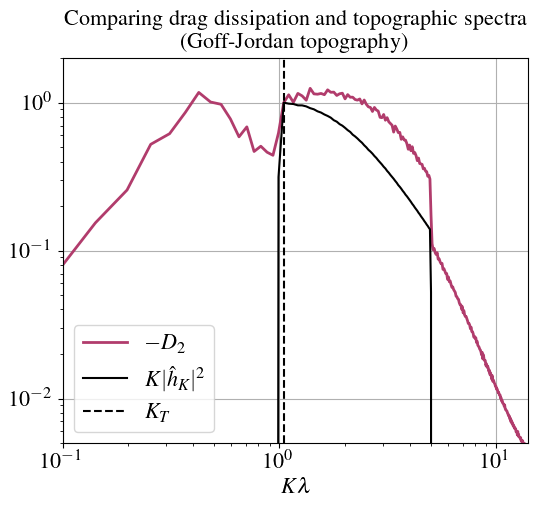

In [92]:
def isotropic_spec(_var):
    '''This function does what pyqg's native calc.ispec does, which relies on having the model instance.
    I therefore mostly copy the synax of their function.
    
    Parameters
    ----------
    var_dens : squared modulus of fourier coefficients like this:
        `np.abs(signal2d_fft)**2/m.M**2`
    
    Returns
    -------
    kr : array
        isotropic wavenumber
    phr : array
        isotropic spectrum
    '''
    
    # variables
    var = np.copy(_var)
    var[..., 0] /= 2
    var[..., -1] /= 2
    
    # grid
    dk = 2 * np.pi / L
    k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
    l = k
    kk, ll = np.meshgrid(k, l)
    KK = np.sqrt(kk ** 2 + ll ** 2)
    
    k_max = np.abs(k).max()
    l_max = np.abs(l).max()
    K_max = np.minimum(k_max, l_max)
    K_min = 0.
    
    dk = k[1] - k[0]
    dl = l[1] - l[0]
    dK = np.sqrt(dk ** 2 + dl ** 2)
    
    # left border of bins
    K = np.arange(K_min, K_max, dK)
    ph = np.zeros(K.size)
    
    for i in range(K.size):
        if i == K.size - 1:
            fK = (KK >= K[i]) & (KK <= K[i] + dK)
        else:
            fK = (KK >= K[i]) & (KK < K[i + 1])
            
        ph[i] = 2 * np.pi * var[fK].mean() * (K[i] + dK / 2) / (dk * dl)
        
    # convert left border of the bin to center
    K = K + dK / 2
    
    return K, ph

### Import topography from one of my simulations ###

name = 'kappa02_GJ_h12'
ds = expt_dict[name]
h = ds.htop.values

### Parameters ###

Ld = 15e3
kd = 1 / Ld
ld = 2 * np.pi / kd
L = 25 * ld
N = 1024
x = np.linspace(0., L, N)
y = np.linspace(0., L, N)
xx, yy = np.meshgrid(x, y)
    
# Define horizontal structure of PV
dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2
K = np.sqrt(K2)

f0 = 1e-4
U0 = 0.01
H0 = 4000.

# Get topographic spectrum

h = ds.htop.values
hrms = np.sqrt(np.mean(h ** 2))
hh = np.fft.fftn(h, axes = (-2, -1))
Kr, h_spec = isotropic_spec(np.abs(hh) ** 2 / hrms ** 2)

# Get drag dissipation spectrum
K = (ds.K * Ld)
DragFlux2 =  Ld / U0**3 * ds.DragFlux2.mean('t')

imin = 1
imax = 200
ymin = 5e-3
ymax = 2

plt.figure(figsize = (6,5))

fontsize = 16

D2 = np.diff(DragFlux2)
plt.plot(Kr * Ld, D2[:Kr.size] / D2[np.argmax(h_spec)], label = r'$-D_2$', color = DragFlux_colour, linewidth = linewidth)
plt.plot(Kr * Ld, h_spec / h_spec[np.argmax(h_spec)], '-', color = 'k', label = r'$K|\hat{h}_{K}|^2$')
plt.vlines(Kr[np.argmax(h_spec)] * Ld, ymin, ymax, colors = 'k', linestyles = '--', label = r'$K_T$')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = fontsize)
plt.ylim([ymin, ymax])
plt.xlim([0.1, 14])
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r'$K \lambda$', fontsize = fontsize)
plt.title('Comparing drag dissipation and topographic spectra \n (Goff-Jordan topography)', fontsize = fontsize, pad = 7.5)
plt.savefig('drag_dissipation_spectrum_GJ.pdf', dpi=500, bbox_inches='tight')

### Three layer eddy scale sweep

In [18]:
path = '/scratch/mp6191/GeophysicalFlows_expts/3LayerRuns'

expts = ['/kappa02_notopo', '/kappa02_kt50_h2', '/kappa02_kt50_h4', '/kappa02_kt50_h5', '/kappa02_kt50_h6', '/kappa02_kt50_h6.5', '/kappa02_kt50_h7', '/kappa02_kt50_h8', '/kappa02_kt50_h10', '/kappa02_kt50_h12',
        '/kappa03_notopo', '/kappa03_kt25_h2', '/kappa03_kt25_h3', '/kappa03_kt25_h4', '/kappa03_kt25_h6', '/kappa03_kt25_h8', '/kappa03_kt25_h10', '/kappa03_kt25_h12',
        '/kappa04_notopo', '/kappa04_kt25_h1', '/kappa04_kt25_h2', '/kappa04_kt25_h3', '/kappa04_kt25_h4', '/kappa04_kt25_h6', '/kappa04_kt25_h8', '/kappa04_kt25_h10', '/kappa04_kt25_h12']
names = [expt[1:] for expt in expts]
paths = [path + expt + '_si' + '/output' + expt + '.nc' for expt in expts]

# Import simulations
expt_dict = dict()
for i in range(len(expts)):
    name = names[i]
    path = paths[i]
    if name == 'kappa02_kt50_h6':
        path = '/scratch/mp6191/GeophysicalFlows_expts/3LayerRuns/kappa02_kt50_h6_si/output/kappa02_kt50_h6_restart3.nc'
    if name == 'kappa02_kt50_h6.5':
        path = '/scratch/mp6191/GeophysicalFlows_expts/3LayerRuns/kappa02_kt50_h6.5_si/output/kappa02_kt50_h6.5_restart1.nc'
    ds = xr.open_dataset(path)
    expt_dict[name] = ds

names_k2 = ['kappa02_notopo', 'kappa02_kt50_h2', 'kappa02_kt50_h4', 'kappa02_kt50_h5', 'kappa02_kt50_h6', 'kappa02_kt50_h6.5', 'kappa02_kt50_h7', 'kappa02_kt50_h8', 'kappa02_kt50_h10', 'kappa02_kt50_h12'] 
names_k3 = ['kappa03_notopo', 'kappa03_kt25_h2', 'kappa03_kt25_h3', 'kappa03_kt25_h4', 'kappa03_kt25_h6', 'kappa03_kt25_h8', 'kappa03_kt25_h10', 'kappa03_kt25_h12']
names_k4 = ['kappa04_notopo', 'kappa04_kt25_h1', 'kappa04_kt25_h2', 'kappa04_kt25_h3', 'kappa04_kt25_h4', 'kappa04_kt25_h6', 'kappa04_kt25_h8', 'kappa04_kt25_h10', 'kappa04_kt25_h12']

In [22]:
def topographic_velocity(h):

    h = Hi / H0 * h     # I have to do this step because of an error in how I saved the htop field...
    
    eta = f0 / H0 * h
    etah = np.fft.fftn(eta, axes=(-2, -1))
    
    psiTh = etah / K2
    psiTh[0,0] = 0
    psiT = np.real(np.fft.ifftn(psiTh, axes = (-2, -1)))
    
    dpsiTdx = np.real(np.fft.ifftn(1j * kk * psiTh, axes = (-2, -1)))
    dpsiTdy = np.real(np.fft.ifftn(1j * ll * psiTh, axes = (-2, -1)))
    
    E_T = 0.5 * np.mean(dpsiTdx ** 2 + dpsiTdy ** 2)
    V_T = np.sqrt(2 * E_T)
    
    return V_T

def control_parameter(htop, ds_flat_bottom):
    '''
    Empirical control parameter estimator
    '''

    mix_eff = 1

    V_T = topographic_velocity(htop.values)

    D_vg = ds_flat_bottom.D.sel(t = slice(tave_start * Ld  / U0, None)).mean('t').values.item()
    l_vg = ds_flat_bottom.Lmix.sel(t = slice(tave_start * Ld  / U0, None)).mean('t').values.item()
    
    V_vg = D_vg / (mix_eff * l_vg)

    return V_T / V_vg


### Common parameters for kappa = 0.2, 0.3 ###

Ld = 15e3
kd = 1 / Ld
ld = 2 * np.pi / kd
L = 25 * ld
N = 512
x = np.linspace(0., L, N)
y = np.linspace(0., L, N)
xx, yy = np.meshgrid(x, y)
    
# Define horizontal structure of PV
dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2
K = np.sqrt(K2)

f0 = 1e-4
U0 = 0.01
H0 = 4000.
Hi = H0 / 3

# Monoscale
Ktopo = 1 * kd

Ld = 15e3
U0 = 0.01
tave_start = 150

### Control parameters ###

# kappa = 0.3
hstar = [0, 2, 3, 4, 6, 8, 10, 12]
ds_fb = expt_dict['kappa03_notopo']
control_parameter_k3 = np.array([control_parameter(expt_dict[name].htop, ds_fb) for name in names_k3])

# kappa = 0.4
hstar = [0, 1, 2, 3, 4, 6, 8, 10, 12]
ds_fb = expt_dict['kappa04_notopo']
control_parameter_k4 = np.array([control_parameter(expt_dict[name].htop, ds_fb) for name in names_k4])


### Common parameters for kappa = 0.2 ###

Ld = 15e3
kd = 1 / Ld
ld = 2 * np.pi / kd
L = 50 * ld
N = 1024
x = np.linspace(0., L, N)
y = np.linspace(0., L, N)
xx, yy = np.meshgrid(x, y)
    
# Define horizontal structure of PV
dk = 2 * np.pi / L
k = dk * np.append( np.arange(0, N / 2), np.arange(- N / 2, 0) )
l = k
kk, ll = np.meshgrid(k, l)
K2 = kk ** 2 + ll ** 2
K = np.sqrt(K2)

f0 = 1e-4
U0 = 0.01
H0 = 4000.
Hi = H0 / 3

# Monoscale
Ktopo = 1 * kd

### Control parameters ###

# kappa = 0.2
hstar = [0, 2, 4, 5, 6, 6.5, 7, 8, 10, 12]
ds_fb = expt_dict['kappa02_notopo']
control_parameter_k2 = np.array([control_parameter(expt_dict[name].htop, ds_fb) for name in names_k2])


### Diffusivity ###
D_vg_k2 = (expt_dict[names_k2[0]].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item()
D_vg_k3 = (expt_dict[names_k3[0]].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item()
D_vg_k4 = (expt_dict[names_k4[0]].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item()

D_k2 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item() / (U0 * Ld) for name in names_k2])
D_k3 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item() / (U0 * Ld) for name in names_k3])
D_k4 = np.array([(expt_dict[name].D.sel(t = slice(tave_start * Ld / U0, None)).mean('t')).values.item() / (U0 * Ld) for name in names_k4])

/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: divide by zero encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: divide by zero encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: divide by zero encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykernel_115002/3205655210.py:8: RuntimeWarning: invalid value encountered in divide
  psiTh = etah / K2
/state/partition1/job-53189665/ipykern

/state/partition1/job-53189665/ipykernel_115002/371481528.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
/state/partition1/job-53189665/ipykernel_115002/371481528.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
/state/partition1/job-53189665/ipykernel_115002/371481528.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)


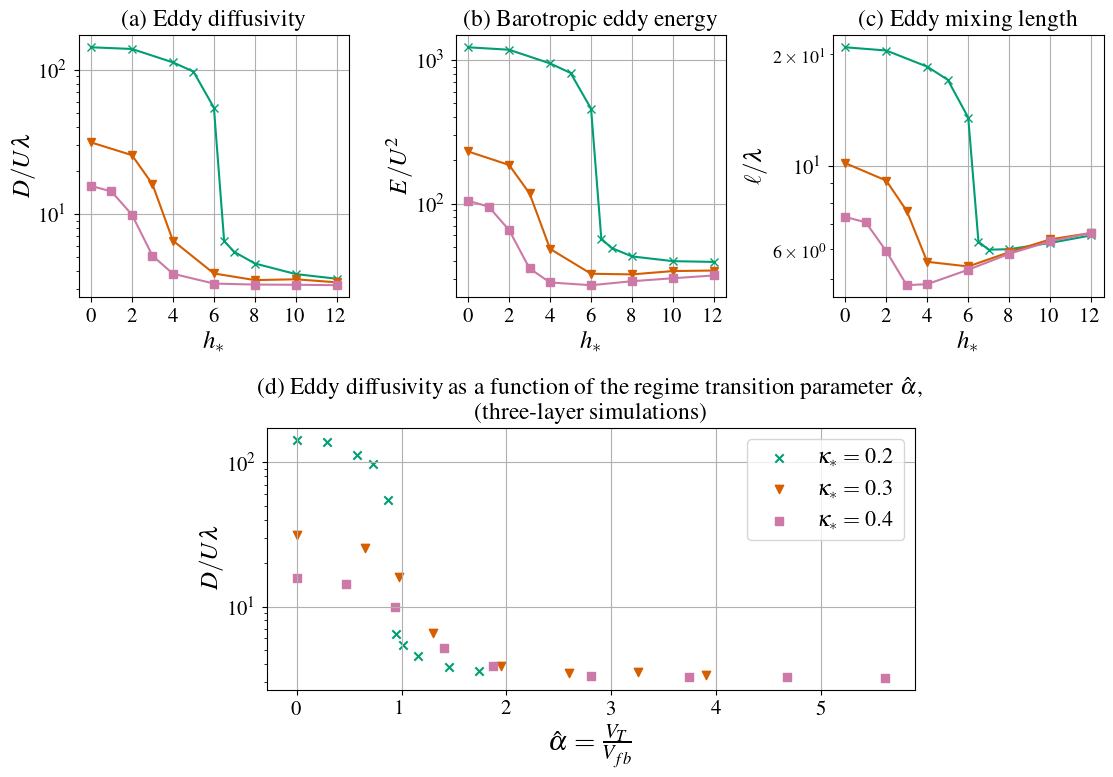

In [23]:
fig, axs = plt.subplots(figsize = (12, 8.2), nrows = 1, ncols = 3)
fig.tight_layout(pad = 5.0)
fontsize = 16

ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)
ax4 = plt.subplot2grid((2, 6), (1, 1), rowspan = 1, colspan = 4)

fig.tight_layout(pad = 5.0)


Ld = 15e3
U0 = 1e-2
tave_start = 150

### Panel (a)
ax = ax1

### kappa* = 0.2 ###

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2]
hstar = [0, 2, 4, 5, 6, 6.5, 7, 8, 10, 12]
ax.plot(hstar, D, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$')


### kappa* = 0.3 ###

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3]
hstar = [0, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, D, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$')


### kappa* = 0.4 ###

D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k4]
hstar = [0, 1, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, D, color = def_colours[5], marker = 's', linestyle = '-', label = r'$\kappa_* = 0.4$')

ax.grid()
ax.set_ylabel(r'$D / U\lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(a) Eddy diffusivity', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.arange(0., 14, 2))


### Panel (b)
ax = ax2

### kappa* = 0.2 ###

E = np.array([expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V.mean('t')**2 / U0**2 for name in names_k2])
hstar = [0, 2, 4, 5, 6, 6.5, 7, 8, 10, 12]
ax.plot(hstar, E, color = def_colours[1], marker = 'x', linestyle = '-')

### kappa* = 0.3 ###

E = np.array([expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V.mean('t')**2 / U0**2 for name in names_k3])
hstar = [0, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, E, color = def_colours[4], marker = 'v', linestyle = '-')

### kappa* = 0.4 ###

E = np.array([expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V.mean('t')**2 / U0**2 for name in names_k4])
hstar = [0, 1, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, E, color = def_colours[5], marker = 's', linestyle = '-')

ax.grid()
ax.set_ylabel(r'$E / U^2$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(b) Barotropic eddy energy', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.arange(0., 14, 2))


### Panel (c)
ax = ax3

### kappa* = 0.2 ###

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld for name in names_k2]
hstar = [0, 2, 4, 5, 6, 6.5, 7, 8, 10, 12]
ax.plot(hstar, L, color = def_colours[1], marker = 'x', linestyle = '-')

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld for name in names_k3]
hstar = [0, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, L, color = def_colours[4], marker = 'v', linestyle = '-')

L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld for name in names_k4]
hstar = [0, 1, 2, 3, 4, 6, 8, 10, 12]
ax.plot(hstar, L, color = def_colours[5], marker = 's', linestyle = '-')

ax.grid()
ax.set_ylabel(r'$ \ell / \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(c) Eddy mixing length', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='minor', labelsize = fontsize - 3)
ax.set_xticks(ticks = np.arange(0., 14, 2))

### Panel (d)
ax = ax4

ax.scatter(control_parameter_k2, D_k2, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$')
ax.scatter(control_parameter_k3, D_k3, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$')
ax.scatter(control_parameter_k4, D_k4, color = def_colours[5], marker = 's', linestyle = '-', label = r'$\kappa_* = 0.4$')

ax.grid()
ax.set_ylabel(r'$D / U \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\hat{\alpha} = \frac{V_T}{V_{fb}}$', fontsize = fontsize + 4)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.linspace(0., 5, 6))
ax.set_yscale('log')
ax.set_title('(d) Eddy diffusivity as a function of the regime transition parameter $\\hat{\\alpha}$, \n (three-layer simulations)', fontsize = fontsize + 1, pad = 7.5)
ax.legend(fontsize = fontsize)

plt.subplots_adjust(wspace = 1.3, hspace = 0.5)

plt.savefig('eddy_scales_three_layer.pdf', dpi = 500, bbox_inches = 'tight')

### Figure B1

In [24]:
# Import L50 runs
path = '/scratch/mp6191/GeophysicalFlows_expts/L50Runs'
expts = ['/kappa016_notopo', '/kappa016_kt50_h2', '/kappa016_kt50_h4', '/kappa016_kt50_h6', '/kappa016_kt50_h6.25', '/kappa016_kt50_h6.5', '/kappa016_kt50_h7', '/kappa016_kt50_h8', '/kappa016_kt50_h10', '/kappa016_kt50_h12', '/kappa016_kt50_h14', '/kappa016_kt50_h16']
names = [expt[1:] for expt in expts]

# Import simulations
expt_dict = dict()
for i in range(len(expts)):
    name = names[i]
    path_kt50 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt50_h6.25']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    elif name in ['kappa016_kt50_h6']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart3.nc'
    ds = xr.open_dataset(path_kt50)
    expt_dict[name] = ds

path = '/scratch/mp6191/GeophysicalFlows_expts/L50Runs'
expts = ['/kappa016_kt100_h1', '/kappa016_kt100_h2', '/kappa016_kt100_h3', '/kappa016_kt100_h4', '/kappa016_kt100_h5', '/kappa016_kt100_h5.5', '/kappa016_kt100_h6', '/kappa016_kt100_h7', '/kappa016_kt100_h8']
names = [expt[1:] for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names[i]
    path_kt100 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt100_h5']:
        path_kt100 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt100)
    expt_dict[name] = ds


# Import L25 runs
path = '/scratch/mp6191/GeophysicalFlows_expts'
expts = ['/kappa02_notopo', '/kappa02_kt25_h2', '/kappa02_kt25_h3', '/kappa02_kt25_h4', '/kappa02_kt25_h4.5', '/kappa02_kt25_h5', '/kappa02_kt25_h6', '/kappa02_kt25_h8', '/kappa02_kt25_h9', '/kappa02_kt25_h10', '/kappa02_kt25_h12', '/kappa02_kt25_h14', '/kappa02_kt25_h16',
         '/kappa03_notopo', '/kappa03_kt25_h1', '/kappa03_kt25_h1.5', '/kappa03_kt25_h2', '/kappa03_kt25_h2.5', '/kappa03_kt25_h3', '/kappa03_kt25_h4', '/kappa03_kt25_h5', '/kappa03_kt25_h6', '/kappa03_kt25_h8', '/kappa03_kt25_h9', '/kappa03_kt25_h10', '/kappa03_kt25_h12', '/kappa03_kt25_h14', '/kappa03_kt25_h16',
        '/kappa10_notopo', '/kappa10_kt25_h2', '/kappa10_kt25_h4', '/kappa10_kt25_h8', '/kappa10_kt25_h12', '/kappa10_kt25_h16']
names = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names[i]
    path_kt25 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa016_kt25_h5.75']:
        path_kt25 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt25)
    expt_dict[name] = ds
    
expts = ['/kappa02_kt50_h1', '/kappa02_kt50_h2', '/kappa02_kt50_h3', '/kappa02_kt50_h3.75', '/kappa02_kt50_h4', '/kappa02_kt50_h5', '/kappa02_kt50_h6', '/kappa02_kt50_h7', '/kappa02_kt50_h8',
         '/kappa03_kt50_h1', '/kappa03_kt50_h2', '/kappa03_kt50_h3', '/kappa03_kt50_h4', '/kappa03_kt50_h5', '/kappa03_kt50_h6', '/kappa03_kt50_h7', '/kappa03_kt50_h8',]
names_kt50 = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names_kt50[i]
    path_kt50 = path + expts[i] + '/output' + expts[i] + '.nc'
    if name in ['kappa015_kt50_h5', 'kappa015_kt50_h5.5']:
        path_kt50 = path + expts[i] + '/output' + expts[i] + '_restart1.nc'
    ds = xr.open_dataset(path_kt50)
    expt_dict[name] = ds
    
expts = ['/kappa02_kt75_h1', '/kappa02_kt75_h2', '/kappa02_kt75_h3', '/kappa02_kt75_h3.5', '/kappa02_kt75_h4', '/kappa02_kt75_h5', '/kappa02_kt75_h6']
names_kt75 = [expt[1:] for expt in expts]
paths = [path + expt + '/output' + expt + '.nc' for expt in expts]

# Import simulations
for i in range(len(expts)):
    name = names_kt75[i]
    ds = xr.open_dataset(paths[i])
    expt_dict[name] = ds

names_k16 = ['kappa016_notopo', 'kappa016_kt50_h2', 'kappa016_kt50_h4', 'kappa016_kt50_h6', 'kappa016_kt50_h6.25', 'kappa016_kt50_h6.5', 'kappa016_kt50_h7', 'kappa016_kt50_h8', 'kappa016_kt50_h10', 'kappa016_kt50_h12', 'kappa016_kt50_h14', 'kappa016_kt50_h16']
names_k2 = ['kappa02_notopo', 'kappa02_kt25_h2', 'kappa02_kt25_h3', 'kappa02_kt25_h4', 'kappa02_kt25_h4.5', 'kappa02_kt25_h5', 'kappa02_kt25_h6', 'kappa02_kt25_h8', 'kappa02_kt25_h9', 'kappa02_kt25_h10', 'kappa02_kt25_h12', 'kappa02_kt25_h14', 'kappa02_kt25_h16']
names_k3 = ['kappa03_notopo', 'kappa03_kt25_h1', 'kappa03_kt25_h1.5', 'kappa03_kt25_h2', 'kappa03_kt25_h2.5', 'kappa03_kt25_h3', 'kappa03_kt25_h4', 'kappa03_kt25_h5', 'kappa03_kt25_h6', 'kappa03_kt25_h8', 'kappa03_kt25_h9', 'kappa03_kt25_h10', 'kappa03_kt25_h12', 'kappa03_kt25_h14', 'kappa03_kt25_h16']

names_k16_kt50 = ['kappa016_kt100_h1', 'kappa016_kt100_h2', 'kappa016_kt100_h3', 'kappa016_kt100_h4', 'kappa016_kt100_h5', 'kappa016_kt100_h5.5', 'kappa016_kt100_h6', 'kappa016_kt100_h7', 'kappa016_kt100_h8'] 
names_k2_kt50 = ['kappa02_kt50_h1', 'kappa02_kt50_h2', 'kappa02_kt50_h3', 'kappa02_kt50_h3.75', 'kappa02_kt50_h4',  'kappa02_kt50_h5', 'kappa02_kt50_h6', 'kappa02_kt50_h7', 'kappa02_kt50_h8']
names_k3_kt50 = ['kappa03_kt50_h1', 'kappa03_kt50_h2', 'kappa03_kt50_h3', 'kappa03_kt50_h4', 'kappa03_kt50_h5', 'kappa03_kt50_h6', 'kappa03_kt50_h7', 'kappa03_kt50_h8']

names_k2_kt75 = ['kappa02_kt75_h1', 'kappa02_kt75_h2', 'kappa02_kt75_h3', 'kappa02_kt75_h3.5', 'kappa02_kt75_h4', 'kappa02_kt75_h5']

names_k10 = ['kappa10_notopo', 'kappa10_kt25_h2', 'kappa10_kt25_h4', 'kappa10_kt25_h8', 'kappa10_kt25_h12', 'kappa10_kt25_h16']

In [26]:
def control_parameter(kappa, h, Kt):
    
    '''
    Note: both of these scalings, with different scaling constants, work depending on how you view where the transition occurs, especially for kappa = 0.3 where the transition is not as sharp.
    '''
    
# GF scaling constants
    c1 = 3.2
    c2 = 0.36
    c3 = 2.45
    c4 = 1.55
    mix_eff = 1

    return ((2 * Kt ** 2 + Kd ** 2) / (Kt ** 2 + Kd ** 2)) * h / (c3 / (mix_eff * c1) * np.exp(c2 / kappa))
    
### Calculate control parameter values ###

Ld = 15e3
Kd = 1 / Ld
U0 = 0.01
tave_start = 350

# GF scaling constants
c1 = 3.2
c2 = 0.36
c3 = 2.45
c4 = 1.55

# control parameters

# kappa = 0.16
hstar = [0., 2., 4., 6., 6.25, 6.5, 7., 8., 10., 12., 14., 16.]
control_parameter_k16 = np.array([control_parameter(0.16, h, Kd) for h in hstar])

hstar = [1., 2., 3., 4., 4.5, 5., 6., 7., 8.]
control_parameter_k16_kt50 = np.array([control_parameter(0.16, h, 2 * Kd) for h in hstar])

# kappa = 0.2
hstar = [0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.]
control_parameter_k2 = np.array([control_parameter(0.2, h, Kd) for h in hstar])

hstar = [1., 2., 3., 3.75, 4., 5., 6., 7., 8.]
control_parameter_k2_kt50 = np.array([control_parameter(0.2, h, 2 * Kd) for h in hstar])

hstar = [1., 2., 3., 3.5, 4., 5.]
control_parameter_k2_kt75 = np.array([control_parameter(0.2, h, 3 * Kd) for h in hstar])

# kappa = 0.3
hstar = [0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.]
control_parameter_k3 = np.array([control_parameter(0.3, h, Kd) for h in hstar])

hstar = [1., 2., 3., 4., 5., 6., 7., 8.]
control_parameter_k3_kt50 = np.array([control_parameter(0.3, h, 2 * Kd) for h in hstar])


### Diffusivity ###
D_k16 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k16])
D_k16[3] = expt_dict[names_k16[3]].D.mean('t') / (U0 * Ld)
D_k16[4] = expt_dict[names_k16[4]].D.mean('t') / (U0 * Ld)
D_k16_kt50 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k16_kt50])
D_k16_kt50[4] = expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).D.mean('t') / (U0 * Ld)

D_k2 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k2])
D_k2[4] = (expt_dict[names_k2[4]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item()
D_k2_kt50 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k2_kt50])
D_k2_kt75 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k2_kt75])
D_k2_kt75[4] = (expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item()

D_k3 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k3])
D_k3_kt50 = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)).values.item() for name in names_k3_kt50])

/state/partition1/job-53189665/ipykernel_115002/3200520311.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
/state/partition1/job-53189665/ipykernel_115002/3200520311.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
/state/partition1/job-53189665/ipykernel_115002/3200520311.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)


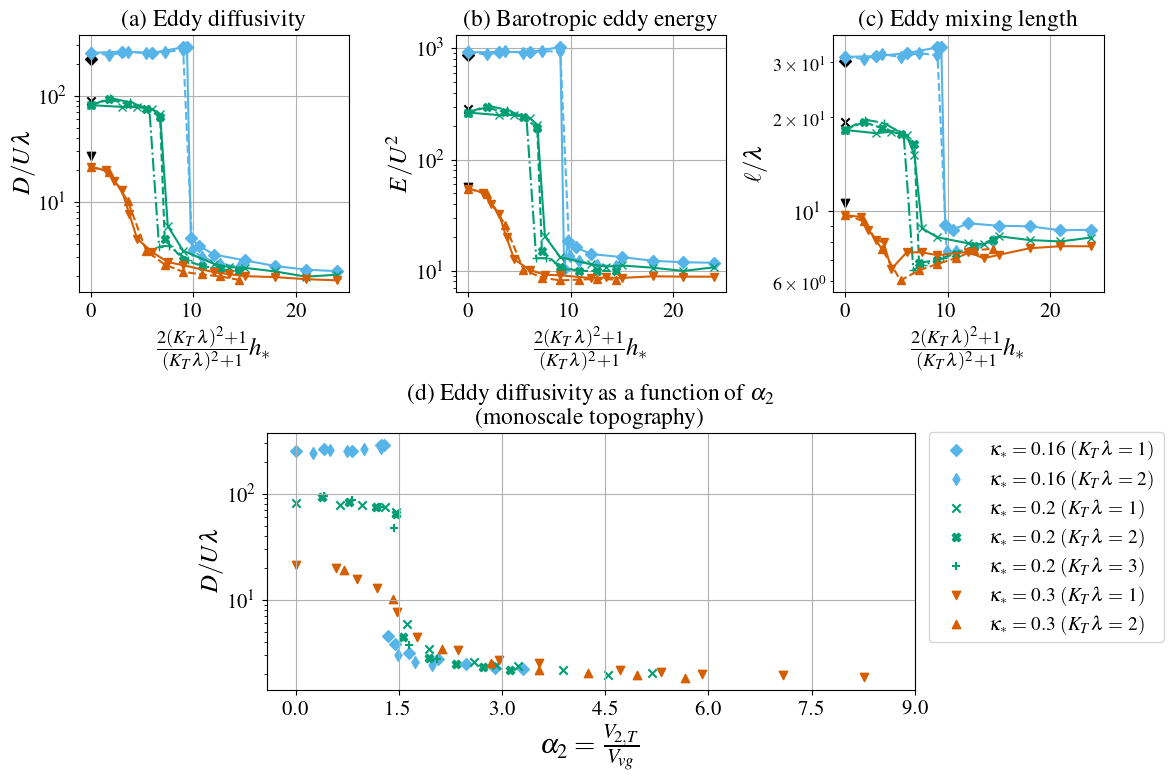

In [34]:
fig, axs = plt.subplots(figsize = (12, 8.2), nrows = 1, ncols = 3)
fig.tight_layout(pad = 5.0)
fontsize = 16

ax1 = plt.subplot2grid((2, 6), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 6), (0, 2), rowspan = 1, colspan = 2)
ax3 = plt.subplot2grid((2, 6), (0, 4), rowspan = 1, colspan = 2)
ax4 = plt.subplot2grid((2, 6), (1, 1), rowspan = 1, colspan = 4)

Ld = 15e3
Kd = 1 / Ld
U0 = 0.01
tave_start = 350

# GF scaling constants
c1 = 3.2
c2 = 0.36
c3 = 2.45
c4 = 1.55

### Panel (a)
ax = ax1

### kappa* = 0.16 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')

Kt = Kd
D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k16]
D[3] = expt_dict[names_k16[3]].D.mean('t') / (U0 * Ld)
D[4] = expt_dict[names_k16[4]].D.mean('t') / (U0 * Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
D1_16, = ax.plot(hstar, D_k16, color = def_colours[-1], marker = 'D', linestyle = '-')

Kt = 2 * Kd
D = [expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k16_kt50]
D[5] = expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).D.mean('t') / (U0 * Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
D2_16, = ax.plot(hstar, D, color = def_colours[-1], marker = 'd', linestyle = '--')


### kappa* = 0.2 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

Kt = Kd
D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2]
D[4] = expt_dict[names_k2[4]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, D, color = def_colours[1], marker = 'x', linestyle = '-') # , label = r'$\kappa_* = 0.2$ $(K_T = k_d)$'

Kt = 2 * Kd
D = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2_kt50]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
ax.plot(hstar, D, color = def_colours[1], marker = 'X', linestyle = '--') # , label = r'$\kappa_* = 0.2$ $(K_T = 2k_d)$'

Kt = 3 * Kd
D = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k2_kt75]
D[5] = expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).D.mean('t') / (U0 * Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.5, 4., 5.])
ax.plot(hstar, D, color = def_colours[1], marker = '+', linestyle = '-.') # , label = r'$\kappa_* = 0.2$ $(K_T = 3k_d)$'
    
### kappa* = 0.3 ###

ax.scatter(0, c3 * np.exp(2 * c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

Kt = Kd
D = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, D, color = def_colours[4], marker = 'v', linestyle = '-') # , label = r'$\kappa_* = 0.3$ $(K_T = k_d)$')

Kt = 2 * Kd
D = [expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).D.mean('t') / (U0 * Ld) for name in names_k3_kt50]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
ax.plot(hstar, D, color = def_colours[4], marker = '^', linestyle = '--') # , label = r'$\kappa_* = 0.3$ $(K_T = 2k_d)$'

ax.grid()
ax.set_ylabel(r'$D / U\lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\frac{2(K_T \lambda)^2 + 1}{(K_T \lambda)^2 + 1} h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
#ax.legend(fontsize = 9, loc = 'center right')
ax.set_title(r'(a) Eddy diffusivity', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)



### Panel (b)
ax = ax2

### kappa* = 0.16 ###

#ax.scatter(0, c4 * np.exp(c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')
ax.scatter(0, c4 * np.exp(2 * c2 / 0.16) / (0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF20)')

Kt = Kd
E = [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k16]
E[3] = (expt_dict[names_k16[3]].V ** 2).mean('t') / U0 ** 2
E[4] = (expt_dict[names_k16[4]].V ** 2).mean('t') / U0
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[-1], marker = 'D', linestyle = '-', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 1)$')

Kt = 2 * Kd
E = [(expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k16_kt50]
E[5] = (expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).V ** 2).mean('t') / U0 ** 2
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[-1], marker = 'd', linestyle = '--', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 2)$')

# For legend purposes
ax.plot(np.zeros(1), np.zeros([1]), color='w', alpha=0, label=' ')

### kappa* = 0.2 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 0.2) / (0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF20)')

Kt = Kd
E = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2])
E[4] = (expt_dict[names_k2[4]].sel(t = slice(530 * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')

Kt = 2 * Kd
E = np.array([(expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2_kt50])
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[1], marker = 'X', linestyle = '--', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')

Kt = 3 * Kd
E = np.array([(expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k2_kt75])
E[5] = (expt_dict[names_k2_kt75[4]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.5, 4., 5.])
ax.plot(hstar, E, color = def_colours[1], marker = '+', linestyle = '-.', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')

### kappa* = 0.3 ###

ax.scatter(0, c4 * np.exp(2 * c2 / 0.3) / (0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF20)')

Kt = Kd
E = np.array([(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k3])
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, E, color = def_colours[4], marker = 'v', linestyle = '-', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')

Kt = 2 * Kd
E = np.array([(expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2] + [(expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).V ** 2).mean('t') / U0 ** 2 for name in names_k3_kt50])
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
ax.plot(hstar, E, color = def_colours[4], marker = '^', linestyle = '--', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')

ax.grid()
ax.set_ylabel(r'$E / U^2$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\frac{2(K_T \lambda)^2 + 1}{(K_T \lambda)^2 + 1} h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(b) Barotropic eddy energy', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)



### Panel (c)
ax = ax3

### kappa* = 0.16 ###

ax.scatter(0, c1 * np.exp(c2 / 0.16), color = 'k', marker = 'D', label = r'$\kappa_* = 0.16$ (GF)')

Kt = Kd
L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld for name in names_k16]
L[3] = expt_dict[names_k16[3]].Lmix.mean('t') / Ld
L[4] = expt_dict[names_k16[4]].Lmix.mean('t') / Ld
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 4., 6, 6.25, 6.5, 7., 8., 10., 12., 14., 16.])
L1_16, = ax.plot(hstar, L, color = def_colours[-1], marker = 'D', linestyle = '-')

Kt = 2 * Kd
L = [expt_dict[names_k16[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / Ld for name in names_k16_kt50]
L[5] = expt_dict[names_k16_kt50[4]].sel(t = slice(1e8, None)).Lmix.mean('t') / Ld
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 5.5, 6., 7., 8.])
L2_16, = ax.plot(hstar, L, color = def_colours[-1], marker = 'd', linestyle = '--')

### kappa* = 0.2 ###

ax.scatter(0, c1 * np.exp(c2 / 0.2), color = 'k', marker = 'x', label = r'$\kappa_* = 0.2$ (GF)')

Kt = Kd
L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2]
L[4] = expt_dict[names_k2[4]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 2., 3., 4., 4.5, 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, L, color = def_colours[1], marker = 'x', linestyle = '-', label = r'$\kappa_* = 0.2$ $(K_T = k_d)$')

Kt = 2 * Kd
L = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2_kt50]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.75, 4., 5., 6., 7., 8.])
ax.plot(hstar, L, color = def_colours[1], marker = 'X', linestyle = '--', label = r'$\kappa_* = 0.2$ $(K_T = 2k_d)$')

Kt = 3 * Kd
L = [expt_dict[names_k2[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k2_kt75]
L[5] = expt_dict[names_k2_kt75[4]].sel(t = slice(530 * Ld / U0, None)).Lmix.mean('t') / (Ld)
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 3.5, 4., 5.])
ax.plot(hstar, L, color = def_colours[1], marker = '+', linestyle = '-.', label = r'$\kappa_* = 0.2$ $(K_T = 3k_d)$')
    
### kappa* = 0.3 ###

ax.scatter(0, c1 * np.exp(c2 / 0.3), color = 'k', marker = 'v', label = r'$\kappa_* = 0.3$ (GF)')

Kt = Kd
L = [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k3]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 1.5, 2., 2.5, 3., 4., 5., 6., 8., 9., 10., 12., 14., 16.])
ax.plot(hstar, L, color = def_colours[4], marker = 'v', linestyle = '-',label = r'$\kappa_* = 0.3$ $(K_T = k_d)$')

Kt = 2 * Kd
L = [expt_dict[names_k3[0]].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld)] + [expt_dict[name].sel(t = slice(tave_start * Ld / U0, None)).Lmix.mean('t') / (Ld) for name in names_k3_kt50]
hstar = (2 * Kt**2 + Kd**2) / (Kt**2 + Kd**2) * np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.])
ax.plot(hstar, L, color = def_colours[4], marker = '^', linestyle = '--', label = r'$\kappa_* = 0.3$ $(K_T = 2k_d)$')

ax.grid()
ax.set_ylabel(r'$ \ell / \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\frac{2(K_T \lambda)^2 + 1}{(K_T \lambda)^2 + 1} h_*$', fontsize = fontsize + 2)
ax.set_yscale('log')
ax.set_title(r'(c) Eddy mixing length', fontsize = fontsize + 1, pad = 7.5)
ax.tick_params(axis='x', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='major', labelsize = fontsize - 1)
ax.tick_params(axis='y', which='minor', labelsize = fontsize - 3)


### Panel (d)

ax = ax4

ax.scatter(control_parameter_k16, D_k16, color = def_colours[-1], marker = 'D', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 1)$')
ax.scatter(control_parameter_k16_kt50, D_k16_kt50, color = def_colours[-1], marker = 'd', label = r'$\kappa_* = 0.16$ $(K_T \lambda = 2)$')

ax.scatter(control_parameter_k2, D_k2, color = def_colours[1], marker = 'x', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 1)$')
ax.scatter(control_parameter_k2_kt50, D_k2_kt50, color = def_colours[1], marker = 'X', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 2)$')
ax.scatter(control_parameter_k2_kt75, D_k2_kt75, color = def_colours[1], marker = '+', label = r'$\kappa_* = 0.2$ $(K_T \lambda = 3)$')

ax.scatter(control_parameter_k3[:-1], D_k3[:-1], color = def_colours[4], marker = 'v', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 1)$')
ax.scatter(control_parameter_k3_kt50, D_k3_kt50, color = def_colours[4], marker = '^', label = r'$\kappa_* = 0.3$ $(K_T \lambda = 2)$')

ax.grid()
ax.set_ylabel(r'$D / U \lambda$', fontsize = fontsize + 2)
ax.set_xlabel(r'$\alpha_2 = \frac{V_{2, T}}{V_{vg}}$', fontsize = fontsize + 4)
ax.tick_params(axis = 'both', labelsize = fontsize - 1)
ax.set_xticks(ticks = np.linspace(0., 9, 7))
ax.set_yscale('log')
ax.set_title('(d) Eddy diffusivity as a function of $\\alpha_2$ \n (monoscale topography)', fontsize = fontsize + 1, pad = 7.5)
ax.legend(fontsize = fontsize - 2, bbox_to_anchor = (1.4, 1.041))

plt.subplots_adjust(wspace = 1.3, hspace = 0.55)

plt.savefig('eddy_scales_lower_layer_parameter.pdf', dpi=500, bbox_inches='tight')

### Misc figures

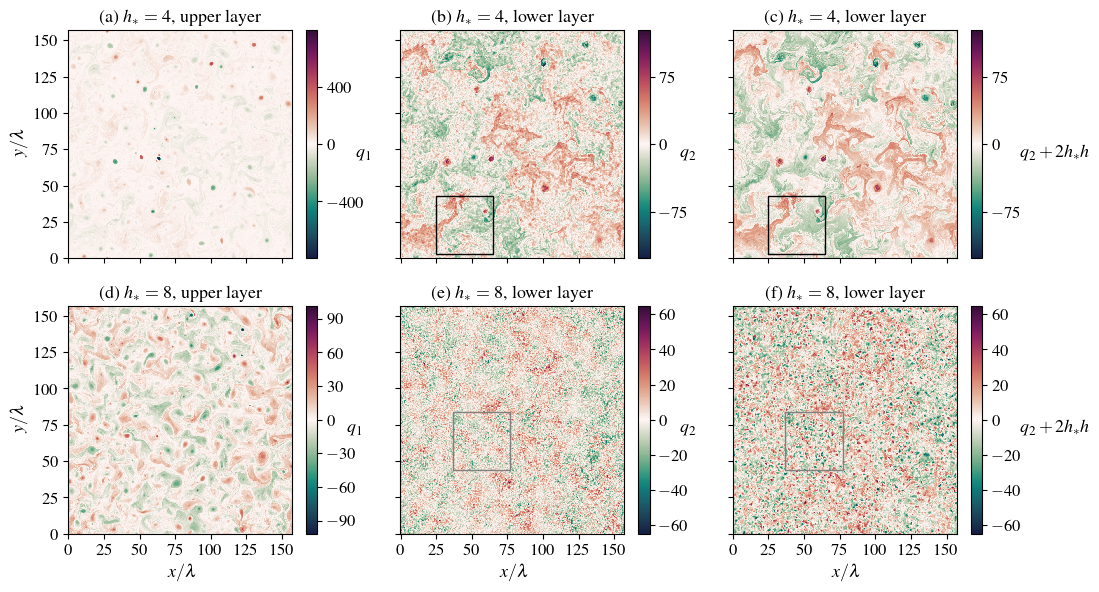

In [11]:
fig, axs = plt.subplots(figsize = (10.5, 6), nrows = 2, ncols = 3, sharey = True, sharex = True)
fig.tight_layout(pad = 2.5)
fontsize = 13

cmap = cm.cm.curl

f0 = 1e-4
H0 = 4e3

### panels (a) and (b) and (c)

name = 'kappa02_GJ_h4'

ds = expt_dict[name].isel(x = slice(0, 1024), y = slice(0, 1024))
q = ds.q.isel(t = -1) * Ld / U0
q1 = q.isel(lev = 0)
q2 = q.isel(lev = 1)
x = q.x
y = q.y
h = ds.htop
eta = f0 / H0 * h * Ld / U0

ax = axs[0, 0]

q1max = np.max(q1.values)
q1min = np.min(q1.values)
vmax = np.max([q1max, -q1min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q1, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-1200, 1200, 7))
cbar.set_label(r'$q_1$', fontsize = fontsize, rotation = 0, labelpad = -1)
cbar.ax.tick_params(labelsize = fontsize - 1)
ax.set_title(r'(a) $h_* = 4$, upper layer', fontsize = fontsize)
ax.set_ylabel('$y / \lambda$', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

ax = axs[0, 1]

q2max = np.max(q2.values)
q2min = np.min(q2.values)
vmax = np.max([q2max, -q2min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q2, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-150, 150, 5))
cbar.set_label(r'$q_2$', fontsize = fontsize, rotation = 0, labelpad = -1)
cbar.ax.tick_params(labelsize = fontsize - 1)
ax.set_title(r'(b) $h_* = 4$, lower layer', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((25, 3), 40, 40, linewidth = 1, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

ax = axs[0, 2]

im = ax.pcolormesh(x / Ld, y / Ld, q2 + 2 * eta, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-150, 150, 5))
cbar.set_label(r'$q_2 + 2 h_* h$', fontsize = fontsize, rotation = 0, labelpad = 24)
cbar.ax.tick_params(labelsize = fontsize - 1)
ax.set_title('(c) $h_* = 4$, lower layer', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((25, 3), 40, 40, linewidth = 1, edgecolor = 'k', facecolor = 'none')
ax.add_patch(rect)

### panels (d) and (e) and (f)

name = 'kappa02_GJ_h8'

ds = expt_dict[name].isel(x = slice(0, 1024), y = slice(0, 1024))
q = ds.q.isel(t = -50) * Ld / U0
q1 = q.isel(lev = 0)
q2 = q.isel(lev = 1)
x = q.x
y = q.y
h = ds.htop
eta = f0 / H0 * h * Ld / U0

ax = axs[1, 0]

q1max = np.max(q1.values)
q1min = np.min(q1.values)
vmax = np.max([q1max, -q1min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q1, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-90, 90, 7))
cbar.ax.tick_params(labelsize = fontsize - 1)
cbar.set_label(r'$q_1$', fontsize = fontsize, rotation = 0, labelpad = -1)
ax.set_title(r'(d) $h_* = 8$, upper layer', fontsize = fontsize)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize)
ax.set_ylabel('$y / \lambda$', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

ax = axs[1, 1]

q2max = np.max(q2.values)
q2min = np.min(q2.values)
vmax = 65 # np.max([q2max, -q2min])
vmin = -vmax

im = ax.pcolormesh(x / Ld, y / Ld, q2, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-60, 60, 7))
cbar.ax.tick_params(labelsize = fontsize - 1)
cbar.set_label(r'$q_2$', fontsize = fontsize, rotation = 0, labelpad = -1)
ax.set_title(r'(e) $h_* = 8$, lower layer', fontsize = fontsize)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((37, 44), 40, 40, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

ax = axs[1, 2]

im = ax.pcolormesh(x / Ld, y / Ld, q2 + 2 * eta, cmap = cmap, vmin = vmin, vmax = vmax)
cbar = plt.colorbar(im, ax = ax, ticks = np.linspace(-60, 60, 7))
cbar.set_label(r'$q_2 + 2 h_* h$', fontsize = fontsize, rotation = 0, labelpad = 24)
cbar.ax.tick_params(labelsize = fontsize - 1)
ax.set_title('(f) $h_* = 8$, lower layer', fontsize = fontsize)
ax.set_xlabel('$x / \lambda$', fontsize = fontsize)
ax.set_ylabel('', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize = fontsize - 1)
ax.set_xticks(np.arange(0, 150 + 25, 25))
ax.set_yticks(np.arange(0, 150 + 25, 25))
ax.xaxis.offsetText.set_fontsize(fontsize - 2)
ax.yaxis.offsetText.set_fontsize(fontsize - 2)

rect = patches.Rectangle((37, 44), 40, 40, linewidth = 1, edgecolor = 'gray', facecolor = 'none')
ax.add_patch(rect)

#plt.savefig('PV_snapshots_GJ.png', dpi=500, bbox_inches='tight')